Import

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive

from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
import math
import tensorflow as tf
import os
import time

from tensorflow import keras
from tensorflow.keras import layers, Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.models import load_model

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
missing_values = ['8888']

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Dataset/Dataset_Curah_Hujan.xlsx', na_values = missing_values)
df

,Tanggal,RR
0,01-01-2019,NaN
1,02-01-2019,0.0
2,03-01-2019,20.5
3,04-01-2019,2.6
4,05-01-2019,0.9
...,...,...
1699,27-08-2023,0.0
1700,28-08-2023,0.0
1701,29-08-2023,0.0
1702,30-08-2023,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Tanggal  1704 non-null   object 
 1   RR       1426 non-null   float64
dtypes: float64(1), object(1)
memory usage: 26.8+ KB


In [ ]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d-%m-%Y')

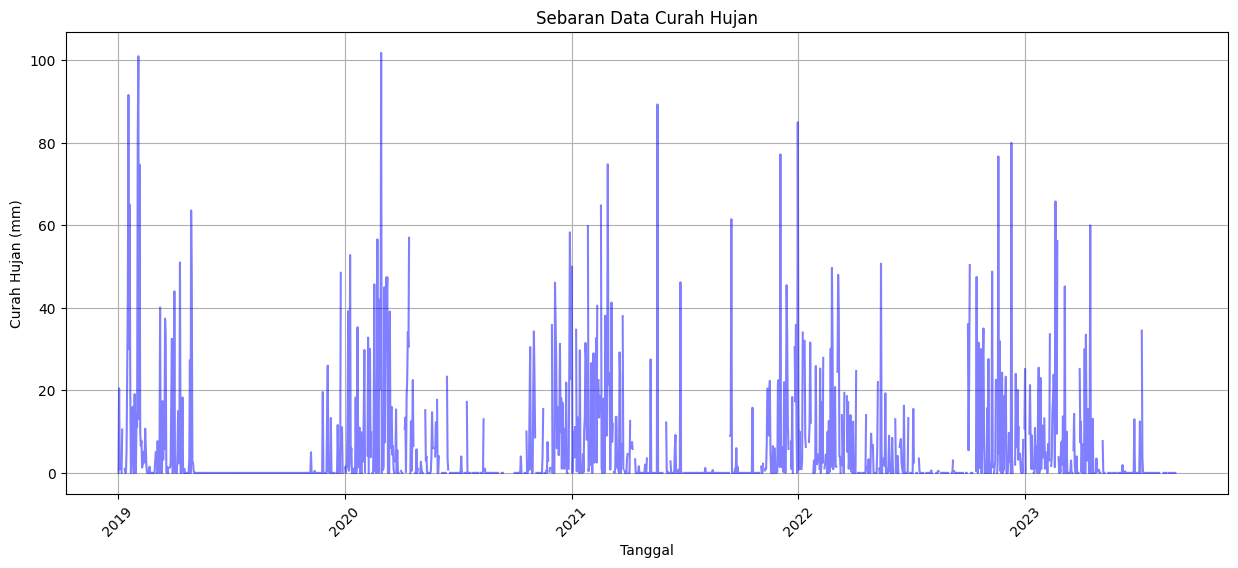

In [ ]:
import matplotlib.pyplot as plt


# Plot scatter plot
plt.figure(figsize=(15, 6))
plt.plot(df['Tanggal'], df['RR'], linestyle='-', color='blue', alpha=0.5)
plt.title('Sebaran Data Curah Hujan')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan (mm)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
df.isnull().sum()

Tanggal      0
RR         278
dtype: int64

In [12]:
# Fitur rating yang akan diimputasi
fitur_imputasi = ['RR']

# Daftar nilai parameter yang ingin dicoba
n_neighbors_list = [3, 4, 5]
epoch_list = [12, 25, 50]
learning_rate_list = [0.01, 0.001, 0.0001]
time_step_list = [25, 50, 75]
#split_data_list = [0.5, 0.6, 0.7, 0.8, 0.9]

# Fungsi untuk membangun dan melatih model LSTM
def build_and_train_lstm(x_train, y_train, x_test, y_test, epochs, learning_rate):
    model = keras.Sequential()
    model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(layers.LSTM(100, return_sequences=False))
    model.add(layers.Dense(25))
    model.add(layers.Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=32, epochs=epochs, verbose=1)
    predictions = model.predict(x_test)
    predictions = np.maximum(predictions, 0)
    predictions = scaler.inverse_transform(predictions)
    data_prediksi_df = pd.DataFrame(predictions)
    prediksi_df = f'results/predictions_knn_n_{n}_epochs_{epochs}_lr_{learning_rate}_ts_{time_steps}.csv'
    data_prediksi_df.to_csv(prediksi_df, index=False)
    rmse = np.sqrt(np.mean(predictions - y_test)**2)
    return model, rmse

# Membuat folder untuk menyimpan hasil
if not os.path.exists('results'):
    os.makedirs('results')

# Loop melalui kombinasi parameter
results = []
skenario = 1


for n in n_neighbors_list:
    # Imputasi data
    preprocessing = KNNImputer(n_neighbors=n)
    data_imputasi = preprocessing.fit_transform(df[fitur_imputasi])
    data_imputasi_df = pd.DataFrame(data_imputasi, columns=fitur_imputasi)
    df_imputed = df.drop(fitur_imputasi, axis=1).join(data_imputasi_df)

    # Simpan data yang diimputasi
    imputasi_file = f'results/imputasi_n_{n}.csv'
    df_imputed.to_csv(imputasi_file, index=False)

    # Normalisasi data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df_imputed[['RR']])
    scaled_data_df = pd.DataFrame(scaled_data)

    # Simpan data yang dinormalisasi
    normalisasi_file = f'results/normalisasi_n_{n}.csv'
    scaled_data_df.to_csv(normalisasi_file, index=False)

    for epochs in epoch_list:
        for learning_rate in learning_rate_list:
            for time_steps in time_step_list:
                # Pembagian data
                values = scaled_data_df.values
                training_data_len = math.ceil(len(values) * 0.7)
                train_data = scaled_data[0:training_data_len, :]

                x_train = []
                y_train = []

                for i in range(time_steps, len(train_data)):
                    x_train.append(train_data[i-time_steps:i, 0])
                    y_train.append(train_data[i, 0])

                x_train, y_train = np.array(x_train), np.array(y_train)
                x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

                test_data = scaled_data[training_data_len-time_steps:, :]
                x_test = []
                y_test = values[training_data_len:]

                for i in range(time_steps, len(test_data)):
                    x_test.append(test_data[i-time_steps:i, 0])

                x_test = np.array(x_test)
                x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

                  # Menyimpan data train dan data testing
                x_train_df = pd.DataFrame({'x_train': x_train.flatten()})
                x_train_file = f'results/xtrain_knn_n_{n}_epochs_{epochs}_lr_{learning_rate}_ts_{time_steps}.csv'
                x_train_df.to_csv(x_train_file, index=False)

                y_train_df = pd.DataFrame({'y_train': y_train.flatten()})
                y_train_file = f'results/ytrain_knn_n_{n}_epochs_{epochs}_lr_{learning_rate}_ts_{time_steps}.csv'
                y_train_df.to_csv(y_train_file, index=False)

                x_test_df = pd.DataFrame({'x_test': x_test.flatten()})
                x_test_file = f'results/xtest_knn_n_{n}_epochs_{epochs}_lr_{learning_rate}_ts_{time_steps}.csv'
                x_test_df.to_csv(x_test_file, index=False)

                y_test_df = pd.DataFrame({'y_test': y_test.flatten()})
                y_test_file = f'results/ytest_knn_n_{n}_epochs_{epochs}_lr_{learning_rate}_ts_{time_steps}.csv'
                y_test_df.to_csv(y_test_file, index=False)

                # Train and evaluate LSTM model
                start_time = time.time()
                model, rmse = build_and_train_lstm(x_train, y_train, x_test, y_test, epochs, learning_rate)
                stop_time = time.time()
                tr_duration = stop_time - start_time

                # Simpan model
                model_file = f'results/model_knn_n_{n}_epochs_{epochs}_lr_{learning_rate}_ts_{time_steps}.h5'
                model.save(model_file)

                # Simpan hasil evaluasi
                results.append([skenario, n, epochs, learning_rate, time_steps, rmse, tr_duration])

                # Print hasil evaluasi
                print(f'Skenario ke-{skenario} : n_neighbors={n}, epochs={epochs}, learning_rate={learning_rate}, time_steps={time_steps}, RMSE={rmse}, duration={tr_duration}')
                skenario += 1

# Simpan semua hasil evaluasi ke CSV
results_df = pd.DataFrame(results, columns=['skenario', 'n_neighbors', 'epochs', 'learning_rate', 'time_steps', 'RMSE', 'duration'])
results_df.to_csv('results/all_results_knn.csv', index=False)

Epoch 1/12
37/37 [==============================] - 6s 40ms/step - loss: 0.0237
Epoch 2/12
37/37 [==============================] - 1s 39ms/step - loss: 0.0146
Epoch 3/12
37/37 [==============================] - 1s 39ms/step - loss: 0.0134
Epoch 4/12
37/37 [==============================] - 1s 39ms/step - loss: 0.0138
Epoch 5/12
37/37 [==============================] - 1s 39ms/step - loss: 0.0135
Epoch 6/12
37/37 [==============================] - 2s 59ms/step - loss: 0.0134
Epoch 7/12
37/37 [==============================] - 2s 65ms/step - loss: 0.0135
Epoch 8/12
37/37 [==============================] - 2s 61ms/step - loss: 0.0133
Epoch 9/12
37/37 [==============================] - 1s 39ms/step - loss: 0.0134
Epoch 10/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0138
Epoch 11/12
37/37 [==============================] - 1s 39ms/step - loss: 0.0136
Epoch 12/12
16/16 [==============================] - 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-1 : n_neighbors=3, epochs=12, learning_rate=0.01, time_steps=25, RMSE=7.151285121489609, duration=27.2837016582489
Epoch 1/12
36/36 [==============================] - 9s 94ms/step - loss: 0.0190
Epoch 2/12
36/36 [==============================] - 3s 73ms/step - loss: 0.0130
Epoch 3/12
36/36 [==============================] - 3s 73ms/step - loss: 0.0125
Epoch 4/12
36/36 [==============================] - 3s 75ms/step - loss: 0.0122
Epoch 5/12
36/36 [==============================] - 4s 114ms/step - loss: 0.0122
Epoch 6/12
36/36 [==============================] - 4s 101ms/step - loss: 0.0122
Epoch 7/12
36/36 [==============================] - 3s 75ms/step - loss: 0.0129
Epoch 8/12
36/36 [==============================] - 3s 75ms/step - loss: 0.0124
Epoch 9/12
36/36 [==============================] - 3s 75ms/step - loss: 0.0121
Epoch 10/12
36/36 [==============================] - 4s 109ms/step - loss: 0.0121
Epoch 11/12
36/36 [==============================] - 4s 107ms/step - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
35/35 [==============================] - 10s 128ms/step - loss: 0.0192
Epoch 2/12
35/35 [==============================] - 4s 106ms/step - loss: 0.0132
Epoch 3/12
35/35 [==============================] - 4s 105ms/step - loss: 0.0124
Epoch 4/12
35/35 [==============================] - 6s 176ms/step - loss: 0.0125
Epoch 5/12
35/35 [==============================] - 4s 105ms/step - loss: 0.0121
Epoch 6/12
35/35 [==============================] - 6s 173ms/step - loss: 0.0121
Epoch 7/12
35/35 [==============================] - 6s 169ms/step - loss: 0.0123
Epoch 8/12
35/35 [==============================] - 4s 111ms/step - loss: 0.0126
Epoch 9/12
35/35 [==============================] - 4s 105ms/step - loss: 0.0122
Epoch 10/12
35/35 [==============================] - 4s 118ms/step - loss: 0.0126
Epoch 11/12
35/35 [==============================] - 5s 157ms/step - loss: 0.0124
Epoch 12/12
16/16 [==============================] - 1s 39ms/step
Skenario ke-3 : n_neighbors=3, epochs=12

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
37/37 [==============================] - 11s 46ms/step - loss: 0.0139
Epoch 2/12
37/37 [==============================] - 2s 47ms/step - loss: 0.0134
Epoch 3/12
37/37 [==============================] - 2s 47ms/step - loss: 0.0135
Epoch 4/12
37/37 [==============================] - 2s 47ms/step - loss: 0.0132
Epoch 5/12
37/37 [==============================] - 2s 52ms/step - loss: 0.0132
Epoch 6/12
37/37 [==============================] - 3s 74ms/step - loss: 0.0134
Epoch 7/12
37/37 [==============================] - 3s 78ms/step - loss: 0.0132
Epoch 8/12
37/37 [==============================] - 2s 49ms/step - loss: 0.0131
Epoch 9/12
37/37 [==============================] - 2s 48ms/step - loss: 0.0132
Epoch 10/12
37/37 [==============================] - 2s 48ms/step - loss: 0.0132
Epoch 11/12
37/37 [==============================] - 2s 49ms/step - loss: 0.0131
Epoch 12/12
16/16 [==============================] - 1s 19ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-4 : n_neighbors=3, epochs=12, learning_rate=0.001, time_steps=25, RMSE=5.9074338046046035, duration=52.016629457473755
Epoch 1/12
36/36 [==============================] - 7s 84ms/step - loss: 0.0129
Epoch 2/12
36/36 [==============================] - 4s 118ms/step - loss: 0.0121
Epoch 3/12
36/36 [==============================] - 4s 112ms/step - loss: 0.0122
Epoch 4/12
36/36 [==============================] - 3s 85ms/step - loss: 0.0122
Epoch 5/12
36/36 [==============================] - 3s 87ms/step - loss: 0.0122
Epoch 6/12
36/36 [==============================] - 3s 94ms/step - loss: 0.0121
Epoch 7/12
36/36 [==============================] - 5s 134ms/step - loss: 0.0120
Epoch 8/12
36/36 [==============================] - 3s 89ms/step - loss: 0.0120
Epoch 9/12
36/36 [==============================] - 3s 85ms/step - loss: 0.0120
Epoch 10/12
36/36 [==============================] - 3s 84ms/step - loss: 0.0122
Epoch 11/12
36/36 [==============================] - 4s 114ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
35/35 [==============================] - 8s 118ms/step - loss: 0.0127
Epoch 2/12
35/35 [==============================] - 6s 187ms/step - loss: 0.0125
Epoch 3/12
35/35 [==============================] - 4s 118ms/step - loss: 0.0121
Epoch 4/12
35/35 [==============================] - 4s 118ms/step - loss: 0.0122
Epoch 5/12
35/35 [==============================] - 6s 166ms/step - loss: 0.0123
Epoch 6/12
35/35 [==============================] - 5s 137ms/step - loss: 0.0120
Epoch 7/12
35/35 [==============================] - 4s 116ms/step - loss: 0.0122
Epoch 8/12
35/35 [==============================] - 5s 135ms/step - loss: 0.0122
Epoch 9/12
35/35 [==============================] - 6s 166ms/step - loss: 0.0120
Epoch 10/12
35/35 [==============================] - 4s 116ms/step - loss: 0.0120
Epoch 11/12
35/35 [==============================] - 4s 117ms/step - loss: 0.0121
Epoch 12/12
16/16 [==============================] - 2s 55ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-6 : n_neighbors=3, epochs=12, learning_rate=0.001, time_steps=75, RMSE=7.103780542005263, duration=88.46800947189331
Epoch 1/12
37/37 [==============================] - 6s 43ms/step - loss: 0.0146
Epoch 2/12
37/37 [==============================] - 2s 43ms/step - loss: 0.0134
Epoch 3/12
37/37 [==============================] - 2s 43ms/step - loss: 0.0134
Epoch 4/12
37/37 [==============================] - 2s 43ms/step - loss: 0.0133
Epoch 5/12
37/37 [==============================] - 2s 47ms/step - loss: 0.0134
Epoch 6/12
37/37 [==============================] - 3s 71ms/step - loss: 0.0133
Epoch 7/12
37/37 [==============================] - 3s 76ms/step - loss: 0.0133
Epoch 8/12
37/37 [==============================] - 2s 45ms/step - loss: 0.0133
Epoch 9/12
37/37 [==============================] - 2s 43ms/step - loss: 0.0133
Epoch 10/12
37/37 [==============================] - 2s 43ms/step - loss: 0.0133
Epoch 11/12
37/37 [==============================] - 2s 44ms/step - lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-7 : n_neighbors=3, epochs=12, learning_rate=0.0001, time_steps=25, RMSE=6.302195286234962, duration=47.669342041015625
Epoch 1/12
36/36 [==============================] - 7s 82ms/step - loss: 0.0136
Epoch 2/12
36/36 [==============================] - 4s 122ms/step - loss: 0.0122
Epoch 3/12
36/36 [==============================] - 4s 105ms/step - loss: 0.0121
Epoch 4/12
36/36 [==============================] - 3s 82ms/step - loss: 0.0121
Epoch 5/12
36/36 [==============================] - 3s 80ms/step - loss: 0.0120
Epoch 6/12
36/36 [==============================] - 3s 88ms/step - loss: 0.0120
Epoch 7/12
36/36 [==============================] - 5s 130ms/step - loss: 0.0121
Epoch 8/12
36/36 [==============================] - 3s 83ms/step - loss: 0.0120
Epoch 9/12
36/36 [==============================] - 3s 81ms/step - loss: 0.0120
Epoch 10/12
36/36 [==============================] - 3s 81ms/step - loss: 0.0120
Epoch 11/12
36/36 [==============================] - 4s 105ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
35/35 [==============================] - 8s 119ms/step - loss: 0.0138
Epoch 2/12
35/35 [==============================] - 6s 177ms/step - loss: 0.0124
Epoch 3/12
35/35 [==============================] - 4s 115ms/step - loss: 0.0122
Epoch 4/12
35/35 [==============================] - 4s 116ms/step - loss: 0.0120
Epoch 5/12
35/35 [==============================] - 6s 165ms/step - loss: 0.0122
Epoch 6/12
35/35 [==============================] - 5s 127ms/step - loss: 0.0120
Epoch 7/12
35/35 [==============================] - 4s 114ms/step - loss: 0.0120
Epoch 8/12
35/35 [==============================] - 5s 137ms/step - loss: 0.0121
Epoch 9/12
35/35 [==============================] - 6s 164ms/step - loss: 0.0121
Epoch 10/12
35/35 [==============================] - 4s 116ms/step - loss: 0.0121
Epoch 11/12
35/35 [==============================] - 4s 115ms/step - loss: 0.0121
Epoch 12/12
16/16 [==============================] - 2s 43ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-9 : n_neighbors=3, epochs=12, learning_rate=0.0001, time_steps=75, RMSE=5.104839514983575, duration=64.39914274215698
Epoch 1/25
37/37 [==============================] - 6s 43ms/step - loss: 0.0203
Epoch 2/25
37/37 [==============================] - 2s 47ms/step - loss: 0.0135
Epoch 3/25
37/37 [==============================] - 3s 70ms/step - loss: 0.0134
Epoch 4/25
37/37 [==============================] - 3s 74ms/step - loss: 0.0136
Epoch 5/25
37/37 [==============================] - 2s 45ms/step - loss: 0.0133
Epoch 6/25
37/37 [==============================] - 2s 44ms/step - loss: 0.0142
Epoch 7/25
37/37 [==============================] - 2s 45ms/step - loss: 0.0138
Epoch 8/25
37/37 [==============================] - 2s 44ms/step - loss: 0.0132
Epoch 9/25
37/37 [==============================] - 2s 43ms/step - loss: 0.0136
Epoch 10/25
37/37 [==============================] - 2s 45ms/step - loss: 0.0134
Epoch 11/25
37/37 [==============================] - 2s 67ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-10 : n_neighbors=3, epochs=25, learning_rate=0.01, time_steps=25, RMSE=5.299915498066753, duration=53.86126136779785
Epoch 1/25
36/36 [==============================] - 9s 108ms/step - loss: 0.0169
Epoch 2/25
36/36 [==============================] - 3s 80ms/step - loss: 0.0125
Epoch 3/25
36/36 [==============================] - 3s 80ms/step - loss: 0.0123
Epoch 4/25
36/36 [==============================] - 3s 79ms/step - loss: 0.0126
Epoch 5/25
36/36 [==============================] - 5s 130ms/step - loss: 0.0130
Epoch 6/25
36/36 [==============================] - 5s 137ms/step - loss: 0.0128
Epoch 7/25
36/36 [==============================] - 4s 111ms/step - loss: 0.0127
Epoch 8/25
36/36 [==============================] - 3s 81ms/step - loss: 0.0125
Epoch 9/25
36/36 [==============================] - 3s 96ms/step - loss: 0.0121
Epoch 10/25
36/36 [==============================] - 5s 129ms/step - loss: 0.0123
Epoch 11/25
36/36 [==============================] - 3s 81ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
35/35 [==============================] - 10s 163ms/step - loss: 0.0170
Epoch 2/25
35/35 [==============================] - 4s 124ms/step - loss: 0.0134
Epoch 3/25
35/35 [==============================] - 4s 109ms/step - loss: 0.0125
Epoch 4/25
35/35 [==============================] - 4s 124ms/step - loss: 0.0127
Epoch 5/25
35/35 [==============================] - 6s 168ms/step - loss: 0.0123
Epoch 6/25
35/35 [==============================] - 4s 110ms/step - loss: 0.0124
Epoch 7/25
35/35 [==============================] - 4s 109ms/step - loss: 0.0123
Epoch 8/25
35/35 [==============================] - 5s 152ms/step - loss: 0.0123
Epoch 9/25
35/35 [==============================] - 5s 138ms/step - loss: 0.0124
Epoch 10/25
35/35 [==============================] - 4s 112ms/step - loss: 0.0126
Epoch 11/25
35/35 [==============================] - 4s 115ms/step - loss: 0.0127
Epoch 12/25
35/35 [==============================] - 6s 180ms/step - loss: 0.0123
Epoch 13/25
35/35 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-12 : n_neighbors=3, epochs=25, learning_rate=0.01, time_steps=75, RMSE=6.522595140236196, duration=148.56157159805298
Epoch 1/25
37/37 [==============================] - 6s 42ms/step - loss: 0.0140
Epoch 2/25
37/37 [==============================] - 2s 42ms/step - loss: 0.0136
Epoch 3/25
37/37 [==============================] - 2s 42ms/step - loss: 0.0134
Epoch 4/25
37/37 [==============================] - 2s 47ms/step - loss: 0.0133
Epoch 5/25
37/37 [==============================] - 3s 80ms/step - loss: 0.0134
Epoch 6/25
37/37 [==============================] - 3s 78ms/step - loss: 0.0134
Epoch 7/25
37/37 [==============================] - 3s 76ms/step - loss: 0.0132
Epoch 8/25
37/37 [==============================] - 3s 71ms/step - loss: 0.0131
Epoch 9/25
37/37 [==============================] - 2s 43ms/step - loss: 0.0131
Epoch 10/25
37/37 [==============================] - 2s 42ms/step - loss: 0.0131
Epoch 11/25
37/37 [==============================] - 2s 42ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-13 : n_neighbors=3, epochs=25, learning_rate=0.001, time_steps=25, RMSE=7.117196617665089, duration=55.95098090171814
Epoch 1/25
36/36 [==============================] - 7s 78ms/step - loss: 0.0128
Epoch 2/25
36/36 [==============================] - 4s 100ms/step - loss: 0.0123
Epoch 3/25
36/36 [==============================] - 4s 121ms/step - loss: 0.0121
Epoch 4/25
36/36 [==============================] - 3s 77ms/step - loss: 0.0123
Epoch 5/25
36/36 [==============================] - 3s 77ms/step - loss: 0.0121
Epoch 6/25
36/36 [==============================] - 3s 77ms/step - loss: 0.0120
Epoch 7/25
36/36 [==============================] - 4s 103ms/step - loss: 0.0120
Epoch 8/25
36/36 [==============================] - 4s 120ms/step - loss: 0.0120
Epoch 9/25
36/36 [==============================] - 3s 79ms/step - loss: 0.0120
Epoch 10/25
36/36 [==============================] - 3s 77ms/step - loss: 0.0120
Epoch 11/25
36/36 [==============================] - 3s 78ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
35/35 [==============================] - 10s 123ms/step - loss: 0.0129
Epoch 2/25
35/35 [==============================] - 4s 107ms/step - loss: 0.0124
Epoch 3/25
35/35 [==============================] - 4s 112ms/step - loss: 0.0124
Epoch 4/25
35/35 [==============================] - 6s 175ms/step - loss: 0.0122
Epoch 5/25
35/35 [==============================] - 4s 106ms/step - loss: 0.0122
Epoch 6/25
35/35 [==============================] - 4s 107ms/step - loss: 0.0122
Epoch 7/25
35/35 [==============================] - 5s 132ms/step - loss: 0.0122
Epoch 8/25
35/35 [==============================] - 5s 152ms/step - loss: 0.0122
Epoch 9/25
35/35 [==============================] - 4s 108ms/step - loss: 0.0123
Epoch 10/25
35/35 [==============================] - 4s 106ms/step - loss: 0.0121
Epoch 11/25
35/35 [==============================] - 5s 154ms/step - loss: 0.0121
Epoch 12/25
35/35 [==============================] - 5s 130ms/step - loss: 0.0121
Epoch 13/25
35/35 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
37/37 [==============================] - 5s 39ms/step - loss: 0.0148
Epoch 2/25
37/37 [==============================] - 2s 63ms/step - loss: 0.0135
Epoch 3/25
37/37 [==============================] - 3s 69ms/step - loss: 0.0134
Epoch 4/25
37/37 [==============================] - 3s 79ms/step - loss: 0.0134
Epoch 5/25
37/37 [==============================] - 2s 66ms/step - loss: 0.0134
Epoch 6/25
37/37 [==============================] - 2s 52ms/step - loss: 0.0133
Epoch 7/25
37/37 [==============================] - 1s 39ms/step - loss: 0.0134
Epoch 8/25
37/37 [==============================] - 2s 41ms/step - loss: 0.0133
Epoch 9/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0133
Epoch 10/25
37/37 [==============================] - 2s 42ms/step - loss: 0.0133
Epoch 11/25
37/37 [==============================] - 2s 65ms/step - loss: 0.0133
Epoch 12/25
37/37 [==============================] - 2s 66ms/step - loss: 0.0133
Epoch 13/25
37/37 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-16 : n_neighbors=3, epochs=25, learning_rate=0.0001, time_steps=25, RMSE=4.854092042177588, duration=52.932852268218994
Epoch 1/25
36/36 [==============================] - 9s 118ms/step - loss: 0.0136
Epoch 2/25
36/36 [==============================] - 3s 75ms/step - loss: 0.0122
Epoch 3/25
36/36 [==============================] - 3s 73ms/step - loss: 0.0121
Epoch 4/25
36/36 [==============================] - 3s 74ms/step - loss: 0.0120
Epoch 5/25
36/36 [==============================] - 3s 88ms/step - loss: 0.0120
Epoch 6/25
36/36 [==============================] - 4s 122ms/step - loss: 0.0120
Epoch 7/25
36/36 [==============================] - 3s 74ms/step - loss: 0.0120
Epoch 8/25
36/36 [==============================] - 3s 74ms/step - loss: 0.0120
Epoch 9/25
36/36 [==============================] - 3s 74ms/step - loss: 0.0120
Epoch 10/25
36/36 [==============================] - 3s 83ms/step - loss: 0.0120
Epoch 11/25
36/36 [==============================] - 4s 119ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
35/35 [==============================] - 8s 105ms/step - loss: 0.0136
Epoch 2/25
35/35 [==============================] - 6s 160ms/step - loss: 0.0123
Epoch 3/25
35/35 [==============================] - 4s 120ms/step - loss: 0.0121
Epoch 4/25
35/35 [==============================] - 4s 107ms/step - loss: 0.0121
Epoch 5/25
35/35 [==============================] - 4s 112ms/step - loss: 0.0121
Epoch 6/25
35/35 [==============================] - 6s 169ms/step - loss: 0.0123
Epoch 7/25
35/35 [==============================] - 4s 105ms/step - loss: 0.0121
Epoch 8/25
35/35 [==============================] - 4s 105ms/step - loss: 0.0122
Epoch 9/25
35/35 [==============================] - 5s 131ms/step - loss: 0.0120
Epoch 10/25
35/35 [==============================] - 5s 148ms/step - loss: 0.0121
Epoch 11/25
35/35 [==============================] - 4s 105ms/step - loss: 0.0120
Epoch 12/25
35/35 [==============================] - 4s 105ms/step - loss: 0.0121
Epoch 13/25
35/35 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-18 : n_neighbors=3, epochs=25, learning_rate=0.0001, time_steps=75, RMSE=5.578215373609595, duration=116.18904781341553
Epoch 1/50
37/37 [==============================] - 5s 44ms/step - loss: 0.0242
Epoch 2/50
37/37 [==============================] - 2s 65ms/step - loss: 0.0133
Epoch 3/50
37/37 [==============================] - 2s 67ms/step - loss: 0.0137
Epoch 4/50
37/37 [==============================] - 2s 46ms/step - loss: 0.0134
Epoch 5/50
37/37 [==============================] - 1s 39ms/step - loss: 0.0139
Epoch 6/50
37/37 [==============================] - 1s 39ms/step - loss: 0.0132
Epoch 7/50
37/37 [==============================] - 1s 40ms/step - loss: 0.0137
Epoch 8/50
37/37 [==============================] - 1s 39ms/step - loss: 0.0138
Epoch 9/50
37/37 [==============================] - 1s 39ms/step - loss: 0.0140
Epoch 10/50
37/37 [==============================] - 1s 39ms/step - loss: 0.0136
Epoch 11/50
37/37 [==============================] - 2s 62ms/step -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-19 : n_neighbors=3, epochs=50, learning_rate=0.01, time_steps=25, RMSE=6.015574245674234, duration=97.10936212539673
Epoch 1/50
36/36 [==============================] - 7s 93ms/step - loss: 0.0170
Epoch 2/50
36/36 [==============================] - 4s 120ms/step - loss: 0.0133
Epoch 3/50
36/36 [==============================] - 3s 74ms/step - loss: 0.0128
Epoch 4/50
36/36 [==============================] - 3s 75ms/step - loss: 0.0125
Epoch 5/50
36/36 [==============================] - 3s 74ms/step - loss: 0.0126
Epoch 6/50
36/36 [==============================] - 3s 91ms/step - loss: 0.0124
Epoch 7/50
36/36 [==============================] - 4s 121ms/step - loss: 0.0127
Epoch 8/50
36/36 [==============================] - 3s 74ms/step - loss: 0.0122
Epoch 9/50
36/36 [==============================] - 3s 75ms/step - loss: 0.0123
Epoch 10/50
36/36 [==============================] - 3s 74ms/step - loss: 0.0120
Epoch 11/50
36/36 [==============================] - 3s 90ms/step - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-20 : n_neighbors=3, epochs=50, learning_rate=0.01, time_steps=50, RMSE=4.637079929760489, duration=208.39865398406982
Epoch 1/50
35/35 [==============================] - 10s 172ms/step - loss: 0.0253
Epoch 2/50
35/35 [==============================] - 5s 139ms/step - loss: 0.0127
Epoch 3/50
35/35 [==============================] - 4s 124ms/step - loss: 0.0125
Epoch 4/50
35/35 [==============================] - 6s 159ms/step - loss: 0.0129
Epoch 5/50
35/35 [==============================] - 5s 156ms/step - loss: 0.0125
Epoch 6/50
35/35 [==============================] - 6s 184ms/step - loss: 0.0124
Epoch 7/50
35/35 [==============================] - 6s 182ms/step - loss: 0.0122
Epoch 8/50
35/35 [==============================] - 5s 128ms/step - loss: 0.0121
Epoch 9/50
35/35 [==============================] - 4s 123ms/step - loss: 0.0124
Epoch 10/50
35/35 [==============================] - 6s 171ms/step - loss: 0.0123
Epoch 11/50
35/35 [==============================] - 5s 13

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
37/37 [==============================] - 7s 48ms/step - loss: 0.0141
Epoch 2/50
37/37 [==============================] - 2s 48ms/step - loss: 0.0138
Epoch 3/50
37/37 [==============================] - 2s 47ms/step - loss: 0.0134
Epoch 4/50
37/37 [==============================] - 2s 47ms/step - loss: 0.0136
Epoch 5/50
37/37 [==============================] - 2s 47ms/step - loss: 0.0133
Epoch 6/50
37/37 [==============================] - 3s 75ms/step - loss: 0.0131
Epoch 7/50
37/37 [==============================] - 3s 76ms/step - loss: 0.0131
Epoch 8/50
37/37 [==============================] - 2s 56ms/step - loss: 0.0132
Epoch 9/50
37/37 [==============================] - 2s 46ms/step - loss: 0.0134
Epoch 10/50
37/37 [==============================] - 2s 46ms/step - loss: 0.0133
Epoch 11/50
37/37 [==============================] - 2s 47ms/step - loss: 0.0130
Epoch 12/50
37/37 [==============================] - 2s 47ms/step - loss: 0.0130
Epoch 13/50
37/37 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
36/36 [==============================] - 8s 129ms/step - loss: 0.0125
Epoch 2/50
36/36 [==============================] - 4s 99ms/step - loss: 0.0121
Epoch 3/50
36/36 [==============================] - 3s 84ms/step - loss: 0.0121
Epoch 4/50
36/36 [==============================] - 3s 85ms/step - loss: 0.0121
Epoch 5/50
36/36 [==============================] - 4s 104ms/step - loss: 0.0122
Epoch 6/50
36/36 [==============================] - 4s 124ms/step - loss: 0.0120
Epoch 7/50
36/36 [==============================] - 3s 85ms/step - loss: 0.0120
Epoch 8/50
36/36 [==============================] - 3s 85ms/step - loss: 0.0120
Epoch 9/50
36/36 [==============================] - 3s 86ms/step - loss: 0.0120
Epoch 10/50
36/36 [==============================] - 5s 134ms/step - loss: 0.0121
Epoch 11/50
36/36 [==============================] - 3s 95ms/step - loss: 0.0119
Epoch 12/50
36/36 [==============================] - 3s 87ms/step - loss: 0.0121
Epoch 13/50
36/36 [==============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-23 : n_neighbors=3, epochs=50, learning_rate=0.001, time_steps=50, RMSE=4.044710571189414, duration=208.06960320472717
Epoch 1/50
35/35 [==============================] - 10s 118ms/step - loss: 0.0128
Epoch 2/50
35/35 [==============================] - 4s 117ms/step - loss: 0.0125
Epoch 3/50
35/35 [==============================] - 6s 163ms/step - loss: 0.0122
Epoch 4/50
35/35 [==============================] - 5s 134ms/step - loss: 0.0123
Epoch 5/50
35/35 [==============================] - 4s 118ms/step - loss: 0.0121
Epoch 6/50
35/35 [==============================] - 5s 141ms/step - loss: 0.0122
Epoch 7/50
35/35 [==============================] - 6s 162ms/step - loss: 0.0121
Epoch 8/50
35/35 [==============================] - 4s 118ms/step - loss: 0.0120
Epoch 9/50
35/35 [==============================] - 4s 118ms/step - loss: 0.0121
Epoch 10/50
35/35 [==============================] - 7s 189ms/step - loss: 0.0120
Epoch 11/50
35/35 [==============================] - 4s 1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-24 : n_neighbors=3, epochs=50, learning_rate=0.001, time_steps=75, RMSE=4.5197439754476045, duration=269.67175006866455
Epoch 1/50
37/37 [==============================] - 6s 66ms/step - loss: 0.0143
Epoch 2/50
37/37 [==============================] - 3s 71ms/step - loss: 0.0134
Epoch 3/50
37/37 [==============================] - 2s 62ms/step - loss: 0.0134
Epoch 4/50
37/37 [==============================] - 2s 44ms/step - loss: 0.0133
Epoch 5/50
37/37 [==============================] - 2s 45ms/step - loss: 0.0134
Epoch 6/50
37/37 [==============================] - 2s 44ms/step - loss: 0.0133
Epoch 7/50
37/37 [==============================] - 2s 44ms/step - loss: 0.0133
Epoch 8/50
37/37 [==============================] - 2s 44ms/step - loss: 0.0133
Epoch 9/50
37/37 [==============================] - 2s 54ms/step - loss: 0.0133
Epoch 10/50
37/37 [==============================] - 3s 71ms/step - loss: 0.0133
Epoch 11/50
37/37 [==============================] - 3s 72ms/step -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
36/36 [==============================] - 7s 82ms/step - loss: 0.0126
Epoch 2/50
36/36 [==============================] - 4s 107ms/step - loss: 0.0120
Epoch 3/50
36/36 [==============================] - 4s 121ms/step - loss: 0.0120
Epoch 4/50
36/36 [==============================] - 3s 81ms/step - loss: 0.0120
Epoch 5/50
36/36 [==============================] - 3s 81ms/step - loss: 0.0120
Epoch 6/50
36/36 [==============================] - 3s 83ms/step - loss: 0.0120
Epoch 7/50
36/36 [==============================] - 4s 121ms/step - loss: 0.0119
Epoch 8/50
36/36 [==============================] - 4s 108ms/step - loss: 0.0120
Epoch 9/50
36/36 [==============================] - 3s 82ms/step - loss: 0.0119
Epoch 10/50
36/36 [==============================] - 3s 82ms/step - loss: 0.0120
Epoch 11/50
36/36 [==============================] - 3s 86ms/step - loss: 0.0119
Epoch 12/50
36/36 [==============================] - 5s 128ms/step - loss: 0.0119
Epoch 13/50
36/36 [=============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
35/35 [==============================] - 10s 184ms/step - loss: 0.0133
Epoch 2/50
35/35 [==============================] - 4s 119ms/step - loss: 0.0122
Epoch 3/50
35/35 [==============================] - 4s 119ms/step - loss: 0.0121
Epoch 4/50
35/35 [==============================] - 6s 162ms/step - loss: 0.0122
Epoch 5/50
35/35 [==============================] - 5s 137ms/step - loss: 0.0121
Epoch 6/50
35/35 [==============================] - 4s 117ms/step - loss: 0.0121
Epoch 7/50
35/35 [==============================] - 5s 138ms/step - loss: 0.0121
Epoch 8/50
35/35 [==============================] - 7s 208ms/step - loss: 0.0122
Epoch 9/50
35/35 [==============================] - 5s 151ms/step - loss: 0.0120
Epoch 10/50
35/35 [==============================] - 5s 141ms/step - loss: 0.0120
Epoch 11/50
35/35 [==============================] - 5s 156ms/step - loss: 0.0121
Epoch 12/50
35/35 [==============================] - 4s 118ms/step - loss: 0.0121
Epoch 13/50
35/35 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-27 : n_neighbors=3, epochs=50, learning_rate=0.0001, time_steps=75, RMSE=5.562403056856902, duration=268.0914330482483
Epoch 1/12
37/37 [==============================] - 6s 44ms/step - loss: 0.0242
Epoch 2/12
37/37 [==============================] - 2s 57ms/step - loss: 0.0143
Epoch 3/12
37/37 [==============================] - 3s 71ms/step - loss: 0.0138
Epoch 4/12
37/37 [==============================] - 3s 70ms/step - loss: 0.0137
Epoch 5/12
37/37 [==============================] - 2s 45ms/step - loss: 0.0134
Epoch 6/12
37/37 [==============================] - 2s 45ms/step - loss: 0.0134
Epoch 7/12
37/37 [==============================] - 2s 45ms/step - loss: 0.0136
Epoch 8/12
37/37 [==============================] - 2s 44ms/step - loss: 0.0137
Epoch 9/12
37/37 [==============================] - 2s 44ms/step - loss: 0.0137
Epoch 10/12
37/37 [==============================] - 2s 48ms/step - loss: 0.0137
Epoch 11/12
37/37 [==============================] - 3s 71ms/step - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-28 : n_neighbors=4, epochs=12, learning_rate=0.01, time_steps=25, RMSE=5.339383715656837, duration=30.60162615776062
Epoch 1/12
36/36 [==============================] - 7s 82ms/step - loss: 0.0187
Epoch 2/12
36/36 [==============================] - 4s 109ms/step - loss: 0.0125
Epoch 3/12
36/36 [==============================] - 4s 118ms/step - loss: 0.0129
Epoch 4/12
36/36 [==============================] - 3s 81ms/step - loss: 0.0127
Epoch 5/12
36/36 [==============================] - 3s 81ms/step - loss: 0.0124
Epoch 6/12
36/36 [==============================] - 3s 82ms/step - loss: 0.0126
Epoch 7/12
36/36 [==============================] - 4s 126ms/step - loss: 0.0124
Epoch 8/12
36/36 [==============================] - 4s 97ms/step - loss: 0.0121
Epoch 9/12
36/36 [==============================] - 3s 82ms/step - loss: 0.0122
Epoch 10/12
36/36 [==============================] - 3s 82ms/step - loss: 0.0120
Epoch 11/12
36/36 [==============================] - 3s 96ms/step -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
35/35 [==============================] - 8s 121ms/step - loss: 0.0202
Epoch 2/12
35/35 [==============================] - 6s 173ms/step - loss: 0.0132
Epoch 3/12
35/35 [==============================] - 4s 112ms/step - loss: 0.0123
Epoch 4/12
35/35 [==============================] - 4s 112ms/step - loss: 0.0131
Epoch 5/12
35/35 [==============================] - 5s 154ms/step - loss: 0.0129
Epoch 6/12
35/35 [==============================] - 5s 136ms/step - loss: 0.0123
Epoch 7/12
35/35 [==============================] - 4s 112ms/step - loss: 0.0125
Epoch 8/12
35/35 [==============================] - 4s 122ms/step - loss: 0.0126
Epoch 9/12
35/35 [==============================] - 6s 165ms/step - loss: 0.0124
Epoch 10/12
35/35 [==============================] - 4s 112ms/step - loss: 0.0124
Epoch 11/12
35/35 [==============================] - 4s 111ms/step - loss: 0.0121
Epoch 12/12
16/16 [==============================] - 2s 58ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-30 : n_neighbors=4, epochs=12, learning_rate=0.01, time_steps=75, RMSE=7.192071554382919, duration=88.53728079795837
Epoch 1/12
37/37 [==============================] - 6s 43ms/step - loss: 0.0137
Epoch 2/12
37/37 [==============================] - 2s 43ms/step - loss: 0.0136
Epoch 3/12
37/37 [==============================] - 2s 43ms/step - loss: 0.0136
Epoch 4/12
37/37 [==============================] - 2s 61ms/step - loss: 0.0132
Epoch 5/12
37/37 [==============================] - 3s 68ms/step - loss: 0.0135
Epoch 6/12
37/37 [==============================] - 3s 68ms/step - loss: 0.0133
Epoch 7/12
37/37 [==============================] - 2s 42ms/step - loss: 0.0130
Epoch 8/12
37/37 [==============================] - 2s 43ms/step - loss: 0.0132
Epoch 9/12
37/37 [==============================] - 2s 43ms/step - loss: 0.0131
Epoch 10/12
37/37 [==============================] - 2s 43ms/step - loss: 0.0131
Epoch 11/12
37/37 [==============================] - 2s 42ms/step - lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-31 : n_neighbors=4, epochs=12, learning_rate=0.001, time_steps=25, RMSE=8.923655235974719, duration=27.868420362472534
Epoch 1/12
36/36 [==============================] - 8s 79ms/step - loss: 0.0128
Epoch 2/12
36/36 [==============================] - 3s 79ms/step - loss: 0.0121
Epoch 3/12
36/36 [==============================] - 3s 91ms/step - loss: 0.0121
Epoch 4/12
36/36 [==============================] - 4s 124ms/step - loss: 0.0121
Epoch 5/12
36/36 [==============================] - 3s 84ms/step - loss: 0.0122
Epoch 6/12
36/36 [==============================] - 3s 79ms/step - loss: 0.0121
Epoch 7/12
36/36 [==============================] - 3s 78ms/step - loss: 0.0121
Epoch 8/12
36/36 [==============================] - 3s 92ms/step - loss: 0.0120
Epoch 9/12
36/36 [==============================] - 4s 123ms/step - loss: 0.0121
Epoch 10/12
36/36 [==============================] - 3s 79ms/step - loss: 0.0121
Epoch 11/12
36/36 [==============================] - 3s 79ms/step 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
35/35 [==============================] - 9s 109ms/step - loss: 0.0133
Epoch 2/12
35/35 [==============================] - 4s 109ms/step - loss: 0.0123
Epoch 3/12
35/35 [==============================] - 6s 161ms/step - loss: 0.0124
Epoch 4/12
35/35 [==============================] - 4s 118ms/step - loss: 0.0120
Epoch 5/12
35/35 [==============================] - 4s 108ms/step - loss: 0.0123
Epoch 6/12
35/35 [==============================] - 4s 125ms/step - loss: 0.0121
Epoch 7/12
35/35 [==============================] - 6s 161ms/step - loss: 0.0124
Epoch 8/12
35/35 [==============================] - 4s 109ms/step - loss: 0.0125
Epoch 9/12
35/35 [==============================] - 4s 109ms/step - loss: 0.0121
Epoch 10/12
35/35 [==============================] - 6s 165ms/step - loss: 0.0121
Epoch 11/12
35/35 [==============================] - 5s 132ms/step - loss: 0.0119
Epoch 12/12
16/16 [==============================] - 2s 49ms/step
Skenario ke-33 : n_neighbors=4, epochs=12

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
37/37 [==============================] - 7s 41ms/step - loss: 0.0144
Epoch 2/12
37/37 [==============================] - 2s 41ms/step - loss: 0.0136
Epoch 3/12
37/37 [==============================] - 2s 41ms/step - loss: 0.0134
Epoch 4/12
37/37 [==============================] - 2s 41ms/step - loss: 0.0134
Epoch 5/12
37/37 [==============================] - 2s 42ms/step - loss: 0.0133
Epoch 6/12
37/37 [==============================] - 2s 51ms/step - loss: 0.0133
Epoch 7/12
37/37 [==============================] - 2s 66ms/step - loss: 0.0133
Epoch 8/12
37/37 [==============================] - 3s 68ms/step - loss: 0.0134
Epoch 9/12
37/37 [==============================] - 2s 46ms/step - loss: 0.0132
Epoch 10/12
37/37 [==============================] - 2s 41ms/step - loss: 0.0132
Epoch 11/12
37/37 [==============================] - 2s 42ms/step - loss: 0.0132
Epoch 12/12
16/16 [==============================] - 1s 17ms/step
Skenario ke-34 : n_neighbors=4, epochs=12, learning_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
36/36 [==============================] - 7s 77ms/step - loss: 0.0132
Epoch 2/12
36/36 [==============================] - 3s 91ms/step - loss: 0.0121
Epoch 3/12
36/36 [==============================] - 4s 123ms/step - loss: 0.0120
Epoch 4/12
36/36 [==============================] - 3s 77ms/step - loss: 0.0120
Epoch 5/12
36/36 [==============================] - 3s 76ms/step - loss: 0.0120
Epoch 6/12
36/36 [==============================] - 3s 76ms/step - loss: 0.0120
Epoch 7/12
36/36 [==============================] - 3s 93ms/step - loss: 0.0120
Epoch 8/12
36/36 [==============================] - 4s 122ms/step - loss: 0.0120
Epoch 9/12
36/36 [==============================] - 3s 77ms/step - loss: 0.0120
Epoch 10/12
36/36 [==============================] - 3s 76ms/step - loss: 0.0120
Epoch 11/12
36/36 [==============================] - 3s 77ms/step - loss: 0.0119
Epoch 12/12
16/16 [==============================] - 1s 31ms/step
Skenario ke-35 : n_neighbors=4, epochs=12, learnin

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
35/35 [==============================] - 8s 111ms/step - loss: 0.0133
Epoch 2/12
35/35 [==============================] - 6s 167ms/step - loss: 0.0123
Epoch 3/12
35/35 [==============================] - 4s 108ms/step - loss: 0.0122
Epoch 4/12
35/35 [==============================] - 4s 108ms/step - loss: 0.0122
Epoch 5/12
35/35 [==============================] - 5s 142ms/step - loss: 0.0121
Epoch 6/12
35/35 [==============================] - 5s 141ms/step - loss: 0.0121
Epoch 7/12
35/35 [==============================] - 4s 109ms/step - loss: 0.0121
Epoch 8/12
35/35 [==============================] - 4s 109ms/step - loss: 0.0120
Epoch 9/12
35/35 [==============================] - 6s 170ms/step - loss: 0.0120
Epoch 10/12
35/35 [==============================] - 4s 114ms/step - loss: 0.0121
Epoch 11/12
35/35 [==============================] - 4s 107ms/step - loss: 0.0120
Epoch 12/12
16/16 [==============================] - 2s 53ms/step
Skenario ke-36 : n_neighbors=4, epochs=12

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
37/37 [==============================] - 6s 40ms/step - loss: 0.0177
Epoch 2/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0143
Epoch 3/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0137
Epoch 4/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0138
Epoch 5/25
37/37 [==============================] - 2s 61ms/step - loss: 0.0140
Epoch 6/25
37/37 [==============================] - 2s 67ms/step - loss: 0.0138
Epoch 7/25
37/37 [==============================] - 2s 57ms/step - loss: 0.0136
Epoch 8/25
37/37 [==============================] - 2s 41ms/step - loss: 0.0137
Epoch 9/25
37/37 [==============================] - 2s 41ms/step - loss: 0.0133
Epoch 10/25
37/37 [==============================] - 2s 41ms/step - loss: 0.0132
Epoch 11/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0132
Epoch 12/25
37/37 [==============================] - 2s 41ms/step - loss: 0.0135
Epoch 13/25
37/37 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-37 : n_neighbors=4, epochs=25, learning_rate=0.01, time_steps=25, RMSE=6.056937800365616, duration=51.17299294471741
Epoch 1/25
36/36 [==============================] - 7s 75ms/step - loss: 0.0288
Epoch 2/25
36/36 [==============================] - 4s 111ms/step - loss: 0.0128
Epoch 3/25
36/36 [==============================] - 4s 105ms/step - loss: 0.0129
Epoch 4/25
36/36 [==============================] - 3s 75ms/step - loss: 0.0125
Epoch 5/25
36/36 [==============================] - 3s 76ms/step - loss: 0.0121
Epoch 6/25
36/36 [==============================] - 3s 77ms/step - loss: 0.0123
Epoch 7/25
36/36 [==============================] - 4s 111ms/step - loss: 0.0122
Epoch 8/25
36/36 [==============================] - 4s 102ms/step - loss: 0.0126
Epoch 9/25
36/36 [==============================] - 3s 76ms/step - loss: 0.0121
Epoch 10/25
36/36 [==============================] - 3s 76ms/step - loss: 0.0121
Epoch 11/25
36/36 [==============================] - 3s 75ms/step 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
35/35 [==============================] - 9s 106ms/step - loss: 0.0325
Epoch 2/25
35/35 [==============================] - 4s 105ms/step - loss: 0.0125
Epoch 3/25
35/35 [==============================] - 5s 154ms/step - loss: 0.0123
Epoch 4/25
35/35 [==============================] - 5s 128ms/step - loss: 0.0125
Epoch 5/25
35/35 [==============================] - 4s 106ms/step - loss: 0.0126
Epoch 6/25
35/35 [==============================] - 4s 109ms/step - loss: 0.0122
Epoch 7/25
35/35 [==============================] - 6s 174ms/step - loss: 0.0124
Epoch 8/25
35/35 [==============================] - 4s 107ms/step - loss: 0.0123
Epoch 9/25
35/35 [==============================] - 4s 107ms/step - loss: 0.0124
Epoch 10/25
35/35 [==============================] - 5s 130ms/step - loss: 0.0121
Epoch 11/25
35/35 [==============================] - 5s 147ms/step - loss: 0.0125
Epoch 12/25
35/35 [==============================] - 4s 107ms/step - loss: 0.0124
Epoch 13/25
35/35 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-39 : n_neighbors=4, epochs=25, learning_rate=0.01, time_steps=75, RMSE=4.325567393990843, duration=149.34386086463928
Epoch 1/25
37/37 [==============================] - 12s 53ms/step - loss: 0.0139
Epoch 2/25
37/37 [==============================] - 2s 52ms/step - loss: 0.0135
Epoch 3/25
37/37 [==============================] - 2s 54ms/step - loss: 0.0133
Epoch 4/25
37/37 [==============================] - 3s 74ms/step - loss: 0.0135
Epoch 5/25
37/37 [==============================] - 3s 80ms/step - loss: 0.0133
Epoch 6/25
37/37 [==============================] - 2s 53ms/step - loss: 0.0131
Epoch 7/25
37/37 [==============================] - 2s 54ms/step - loss: 0.0131
Epoch 8/25
37/37 [==============================] - 2s 52ms/step - loss: 0.0132
Epoch 9/25
37/37 [==============================] - 2s 52ms/step - loss: 0.0132
Epoch 10/25
37/37 [==============================] - 2s 53ms/step - loss: 0.0131
Epoch 11/25
37/37 [==============================] - 3s 77ms/step - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
36/36 [==============================] - 8s 90ms/step - loss: 0.0126
Epoch 2/25
36/36 [==============================] - 3s 91ms/step - loss: 0.0123
Epoch 3/25
36/36 [==============================] - 4s 123ms/step - loss: 0.0121
Epoch 4/25
36/36 [==============================] - 4s 118ms/step - loss: 0.0121
Epoch 5/25
36/36 [==============================] - 3s 90ms/step - loss: 0.0123
Epoch 6/25
36/36 [==============================] - 3s 91ms/step - loss: 0.0120
Epoch 7/25
36/36 [==============================] - 4s 108ms/step - loss: 0.0121
Epoch 8/25
36/36 [==============================] - 5s 131ms/step - loss: 0.0120
Epoch 9/25
36/36 [==============================] - 3s 91ms/step - loss: 0.0120
Epoch 10/25
36/36 [==============================] - 3s 91ms/step - loss: 0.0119
Epoch 11/25
36/36 [==============================] - 4s 99ms/step - loss: 0.0118
Epoch 12/25
36/36 [==============================] - 5s 142ms/step - loss: 0.0119
Epoch 13/25
36/36 [=============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-41 : n_neighbors=4, epochs=25, learning_rate=0.001, time_steps=50, RMSE=4.090500305742777, duration=149.37137365341187
Epoch 1/25
35/35 [==============================] - 9s 124ms/step - loss: 0.0128
Epoch 2/25
35/35 [==============================] - 5s 152ms/step - loss: 0.0123
Epoch 3/25
35/35 [==============================] - 6s 157ms/step - loss: 0.0124
Epoch 4/25
35/35 [==============================] - 4s 124ms/step - loss: 0.0121
Epoch 5/25
35/35 [==============================] - 5s 147ms/step - loss: 0.0122
Epoch 6/25
35/35 [==============================] - 6s 166ms/step - loss: 0.0121
Epoch 7/25
35/35 [==============================] - 4s 124ms/step - loss: 0.0123
Epoch 8/25
35/35 [==============================] - 5s 136ms/step - loss: 0.0123
Epoch 9/25
35/35 [==============================] - 6s 177ms/step - loss: 0.0120
Epoch 10/25
35/35 [==============================] - 4s 125ms/step - loss: 0.0121
Epoch 11/25
35/35 [==============================] - 4s 12

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
37/37 [==============================] - 7s 76ms/step - loss: 0.0145
Epoch 2/25
37/37 [==============================] - 2s 64ms/step - loss: 0.0134
Epoch 3/25
37/37 [==============================] - 2s 47ms/step - loss: 0.0135
Epoch 4/25
37/37 [==============================] - 2s 48ms/step - loss: 0.0133
Epoch 5/25
37/37 [==============================] - 2s 48ms/step - loss: 0.0133
Epoch 6/25
37/37 [==============================] - 2s 47ms/step - loss: 0.0133
Epoch 7/25
37/37 [==============================] - 2s 49ms/step - loss: 0.0133
Epoch 8/25
37/37 [==============================] - 3s 68ms/step - loss: 0.0132
Epoch 9/25
37/37 [==============================] - 3s 77ms/step - loss: 0.0132
Epoch 10/25
37/37 [==============================] - 2s 55ms/step - loss: 0.0132
Epoch 11/25
37/37 [==============================] - 2s 49ms/step - loss: 0.0132
Epoch 12/25
37/37 [==============================] - 2s 48ms/step - loss: 0.0134
Epoch 13/25
37/37 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
36/36 [==============================] - 8s 115ms/step - loss: 0.0134
Epoch 2/25
36/36 [==============================] - 4s 117ms/step - loss: 0.0123
Epoch 3/25
36/36 [==============================] - 3s 86ms/step - loss: 0.0121
Epoch 4/25
36/36 [==============================] - 3s 85ms/step - loss: 0.0120
Epoch 5/25
36/36 [==============================] - 3s 91ms/step - loss: 0.0120
Epoch 6/25
36/36 [==============================] - 5s 135ms/step - loss: 0.0120
Epoch 7/25
36/36 [==============================] - 3s 88ms/step - loss: 0.0120
Epoch 8/25
36/36 [==============================] - 3s 87ms/step - loss: 0.0120
Epoch 9/25
36/36 [==============================] - 3s 87ms/step - loss: 0.0120
Epoch 10/25
36/36 [==============================] - 4s 118ms/step - loss: 0.0120
Epoch 11/25
36/36 [==============================] - 4s 114ms/step - loss: 0.0120
Epoch 12/25
36/36 [==============================] - 3s 87ms/step - loss: 0.0120
Epoch 13/25
36/36 [=============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
35/35 [==============================] - 10s 170ms/step - loss: 0.0139
Epoch 2/25
35/35 [==============================] - 5s 134ms/step - loss: 0.0123
Epoch 3/25
35/35 [==============================] - 4s 120ms/step - loss: 0.0121
Epoch 4/25
35/35 [==============================] - 5s 148ms/step - loss: 0.0121
Epoch 5/25
35/35 [==============================] - 7s 197ms/step - loss: 0.0121
Epoch 6/25
35/35 [==============================] - 5s 142ms/step - loss: 0.0121
Epoch 7/25
35/35 [==============================] - 5s 145ms/step - loss: 0.0121
Epoch 8/25
35/35 [==============================] - 6s 157ms/step - loss: 0.0121
Epoch 9/25
35/35 [==============================] - 4s 120ms/step - loss: 0.0121
Epoch 10/25
35/35 [==============================] - 4s 127ms/step - loss: 0.0121
Epoch 11/25
35/35 [==============================] - 6s 170ms/step - loss: 0.0120
Epoch 12/25
35/35 [==============================] - 4s 121ms/step - loss: 0.0120
Epoch 13/25
35/35 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-45 : n_neighbors=4, epochs=25, learning_rate=0.0001, time_steps=75, RMSE=5.490918973558068, duration=148.10816645622253
Epoch 1/50
37/37 [==============================] - 6s 45ms/step - loss: 0.0187
Epoch 2/50
37/37 [==============================] - 2s 47ms/step - loss: 0.0144
Epoch 3/50
37/37 [==============================] - 2s 46ms/step - loss: 0.0132
Epoch 4/50
37/37 [==============================] - 2s 45ms/step - loss: 0.0136
Epoch 5/50
37/37 [==============================] - 2s 47ms/step - loss: 0.0139
Epoch 6/50
37/37 [==============================] - 3s 72ms/step - loss: 0.0134
Epoch 7/50
37/37 [==============================] - 3s 75ms/step - loss: 0.0134
Epoch 8/50
37/37 [==============================] - 2s 49ms/step - loss: 0.0135
Epoch 9/50
37/37 [==============================] - 2s 46ms/step - loss: 0.0134
Epoch 10/50
37/37 [==============================] - 2s 46ms/step - loss: 0.0134
Epoch 11/50
37/37 [==============================] - 2s 46ms/step -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
36/36 [==============================] - 9s 89ms/step - loss: 0.0164
Epoch 2/50
36/36 [==============================] - 3s 86ms/step - loss: 0.0127
Epoch 3/50
36/36 [==============================] - 3s 85ms/step - loss: 0.0125
Epoch 4/50
36/36 [==============================] - 4s 114ms/step - loss: 0.0125
Epoch 5/50
36/36 [==============================] - 4s 113ms/step - loss: 0.0127
Epoch 6/50
36/36 [==============================] - 3s 84ms/step - loss: 0.0123
Epoch 7/50
36/36 [==============================] - 3s 85ms/step - loss: 0.0121
Epoch 8/50
36/36 [==============================] - 4s 99ms/step - loss: 0.0128
Epoch 9/50
36/36 [==============================] - 5s 134ms/step - loss: 0.0118
Epoch 10/50
36/36 [==============================] - 4s 108ms/step - loss: 0.0121
Epoch 11/50
36/36 [==============================] - 5s 126ms/step - loss: 0.0121
Epoch 12/50
36/36 [==============================] - 4s 106ms/step - loss: 0.0124
Epoch 13/50
36/36 [============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-47 : n_neighbors=4, epochs=50, learning_rate=0.01, time_steps=50, RMSE=7.258860143334163, duration=209.6389651298523
Epoch 1/50
35/35 [==============================] - 8s 117ms/step - loss: 0.0180
Epoch 2/50
35/35 [==============================] - 6s 181ms/step - loss: 0.0134
Epoch 3/50
35/35 [==============================] - 4s 121ms/step - loss: 0.0124
Epoch 4/50
35/35 [==============================] - 4s 117ms/step - loss: 0.0126
Epoch 5/50
35/35 [==============================] - 5s 151ms/step - loss: 0.0123
Epoch 6/50
35/35 [==============================] - 5s 150ms/step - loss: 0.0126
Epoch 7/50
35/35 [==============================] - 4s 117ms/step - loss: 0.0131
Epoch 8/50
35/35 [==============================] - 5s 129ms/step - loss: 0.0123
Epoch 9/50
35/35 [==============================] - 6s 172ms/step - loss: 0.0123
Epoch 10/50
35/35 [==============================] - 4s 118ms/step - loss: 0.0121
Epoch 11/50
35/35 [==============================] - 4s 118m

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
37/37 [==============================] - 7s 44ms/step - loss: 0.0139
Epoch 2/50
37/37 [==============================] - 2s 44ms/step - loss: 0.0135
Epoch 3/50
37/37 [==============================] - 2s 44ms/step - loss: 0.0133
Epoch 4/50
37/37 [==============================] - 2s 44ms/step - loss: 0.0134
Epoch 5/50
37/37 [==============================] - 2s 43ms/step - loss: 0.0131
Epoch 6/50
37/37 [==============================] - 2s 53ms/step - loss: 0.0132
Epoch 7/50
37/37 [==============================] - 3s 70ms/step - loss: 0.0132
Epoch 8/50
37/37 [==============================] - 3s 72ms/step - loss: 0.0131
Epoch 9/50
37/37 [==============================] - 2s 44ms/step - loss: 0.0132
Epoch 10/50
37/37 [==============================] - 2s 43ms/step - loss: 0.0130
Epoch 11/50
37/37 [==============================] - 2s 44ms/step - loss: 0.0131
Epoch 12/50
37/37 [==============================] - 2s 44ms/step - loss: 0.0132
Epoch 13/50
37/37 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-49 : n_neighbors=4, epochs=50, learning_rate=0.001, time_steps=25, RMSE=5.990318479973941, duration=149.0231053829193
Epoch 1/50
36/36 [==============================] - 9s 129ms/step - loss: 0.0127
Epoch 2/50
36/36 [==============================] - 3s 82ms/step - loss: 0.0122
Epoch 3/50
36/36 [==============================] - 3s 83ms/step - loss: 0.0122
Epoch 4/50
36/36 [==============================] - 3s 83ms/step - loss: 0.0121
Epoch 5/50
36/36 [==============================] - 4s 114ms/step - loss: 0.0121
Epoch 6/50
36/36 [==============================] - 4s 110ms/step - loss: 0.0119
Epoch 7/50
36/36 [==============================] - 3s 82ms/step - loss: 0.0121
Epoch 8/50
36/36 [==============================] - 3s 81ms/step - loss: 0.0124
Epoch 9/50
36/36 [==============================] - 3s 86ms/step - loss: 0.0120
Epoch 10/50
36/36 [==============================] - 5s 129ms/step - loss: 0.0120
Epoch 11/50
36/36 [==============================] - 3s 93ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
35/35 [==============================] - 9s 113ms/step - loss: 0.0124
Epoch 2/50
35/35 [==============================] - 4s 112ms/step - loss: 0.0122
Epoch 3/50
35/35 [==============================] - 6s 177ms/step - loss: 0.0122
Epoch 4/50
35/35 [==============================] - 4s 115ms/step - loss: 0.0124
Epoch 5/50
35/35 [==============================] - 4s 112ms/step - loss: 0.0121
Epoch 6/50
35/35 [==============================] - 5s 138ms/step - loss: 0.0122
Epoch 7/50
35/35 [==============================] - 5s 149ms/step - loss: 0.0124
Epoch 8/50
35/35 [==============================] - 4s 113ms/step - loss: 0.0123
Epoch 9/50
35/35 [==============================] - 4s 113ms/step - loss: 0.0121
Epoch 10/50
35/35 [==============================] - 6s 177ms/step - loss: 0.0119
Epoch 11/50
35/35 [==============================] - 4s 112ms/step - loss: 0.0121
Epoch 12/50
35/35 [==============================] - 4s 112ms/step - loss: 0.0121
Epoch 13/50
35/35 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
37/37 [==============================] - 5s 44ms/step - loss: 0.0143
Epoch 2/50
37/37 [==============================] - 2s 43ms/step - loss: 0.0135
Epoch 3/50
37/37 [==============================] - 2s 51ms/step - loss: 0.0134
Epoch 4/50
37/37 [==============================] - 3s 69ms/step - loss: 0.0134
Epoch 5/50
37/37 [==============================] - 3s 72ms/step - loss: 0.0133
Epoch 6/50
37/37 [==============================] - 2s 45ms/step - loss: 0.0133
Epoch 7/50
37/37 [==============================] - 2s 43ms/step - loss: 0.0135
Epoch 8/50
37/37 [==============================] - 2s 43ms/step - loss: 0.0133
Epoch 9/50
37/37 [==============================] - 2s 43ms/step - loss: 0.0133
Epoch 10/50
37/37 [==============================] - 2s 43ms/step - loss: 0.0134
Epoch 11/50
37/37 [==============================] - 2s 42ms/step - loss: 0.0133
Epoch 12/50
37/37 [==============================] - 2s 60ms/step - loss: 0.0132
Epoch 13/50
37/37 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-52 : n_neighbors=4, epochs=50, learning_rate=0.0001, time_steps=25, RMSE=6.014753133954098, duration=100.68745803833008
Epoch 1/50
36/36 [==============================] - 8s 120ms/step - loss: 0.0134
Epoch 2/50
36/36 [==============================] - 4s 100ms/step - loss: 0.0122
Epoch 3/50
36/36 [==============================] - 3s 79ms/step - loss: 0.0120
Epoch 4/50
36/36 [==============================] - 3s 79ms/step - loss: 0.0120
Epoch 5/50
36/36 [==============================] - 3s 78ms/step - loss: 0.0120
Epoch 6/50
36/36 [==============================] - 4s 122ms/step - loss: 0.0120
Epoch 7/50
36/36 [==============================] - 3s 94ms/step - loss: 0.0119
Epoch 8/50
36/36 [==============================] - 3s 78ms/step - loss: 0.0120
Epoch 9/50
36/36 [==============================] - 3s 78ms/step - loss: 0.0119
Epoch 10/50
36/36 [==============================] - 3s 83ms/step - loss: 0.0119
Epoch 11/50
36/36 [==============================] - 5s 126ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
35/35 [==============================] - 9s 109ms/step - loss: 0.0128
Epoch 2/50
35/35 [==============================] - 4s 109ms/step - loss: 0.0122
Epoch 3/50
35/35 [==============================] - 5s 132ms/step - loss: 0.0121
Epoch 4/50
35/35 [==============================] - 5s 147ms/step - loss: 0.0121
Epoch 5/50
35/35 [==============================] - 4s 109ms/step - loss: 0.0121
Epoch 6/50
35/35 [==============================] - 4s 109ms/step - loss: 0.0121
Epoch 7/50
35/35 [==============================] - 6s 172ms/step - loss: 0.0120
Epoch 8/50
35/35 [==============================] - 4s 109ms/step - loss: 0.0120
Epoch 9/50
35/35 [==============================] - 4s 109ms/step - loss: 0.0120
Epoch 10/50
35/35 [==============================] - 5s 135ms/step - loss: 0.0120
Epoch 11/50
35/35 [==============================] - 5s 151ms/step - loss: 0.0121
Epoch 12/50
35/35 [==============================] - 4s 109ms/step - loss: 0.0121
Epoch 13/50
35/35 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
37/37 [==============================] - 5s 42ms/step - loss: 0.0233
Epoch 2/12
37/37 [==============================] - 2s 42ms/step - loss: 0.0137
Epoch 3/12
37/37 [==============================] - 2s 41ms/step - loss: 0.0133
Epoch 4/12
37/37 [==============================] - 2s 42ms/step - loss: 0.0148
Epoch 5/12
37/37 [==============================] - 3s 68ms/step - loss: 0.0136
Epoch 6/12
37/37 [==============================] - 3s 69ms/step - loss: 0.0136
Epoch 7/12
37/37 [==============================] - 2s 56ms/step - loss: 0.0136
Epoch 8/12
37/37 [==============================] - 2s 41ms/step - loss: 0.0132
Epoch 9/12
37/37 [==============================] - 2s 42ms/step - loss: 0.0132
Epoch 10/12
37/37 [==============================] - 2s 41ms/step - loss: 0.0136
Epoch 11/12
37/37 [==============================] - 2s 41ms/step - loss: 0.0136
Epoch 12/12
16/16 [==============================] - 1s 17ms/step
Skenario ke-55 : n_neighbors=5, epochs=12, learning_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
36/36 [==============================] - 7s 85ms/step - loss: 0.0182
Epoch 2/12
36/36 [==============================] - 4s 124ms/step - loss: 0.0124
Epoch 3/12
36/36 [==============================] - 3s 85ms/step - loss: 0.0126
Epoch 4/12
36/36 [==============================] - 3s 77ms/step - loss: 0.0124
Epoch 5/12
36/36 [==============================] - 3s 78ms/step - loss: 0.0127
Epoch 6/12
36/36 [==============================] - 3s 89ms/step - loss: 0.0122
Epoch 7/12
36/36 [==============================] - 4s 125ms/step - loss: 0.0130
Epoch 8/12
36/36 [==============================] - 3s 83ms/step - loss: 0.0123
Epoch 9/12
36/36 [==============================] - 3s 77ms/step - loss: 0.0120
Epoch 10/12
36/36 [==============================] - 3s 77ms/step - loss: 0.0122
Epoch 11/12
36/36 [==============================] - 3s 89ms/step - loss: 0.0123
Epoch 12/12
16/16 [==============================] - 2s 30ms/step
Skenario ke-56 : n_neighbors=5, epochs=12, learnin

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
35/35 [==============================] - 8s 109ms/step - loss: 0.0227
Epoch 2/12
35/35 [==============================] - 6s 179ms/step - loss: 0.0126
Epoch 3/12
35/35 [==============================] - 4s 116ms/step - loss: 0.0124
Epoch 4/12
35/35 [==============================] - 4s 108ms/step - loss: 0.0121
Epoch 5/12
35/35 [==============================] - 4s 122ms/step - loss: 0.0128
Epoch 6/12
35/35 [==============================] - 5s 156ms/step - loss: 0.0126
Epoch 7/12
35/35 [==============================] - 4s 107ms/step - loss: 0.0122
Epoch 8/12
35/35 [==============================] - 4s 108ms/step - loss: 0.0131
Epoch 9/12
35/35 [==============================] - 5s 154ms/step - loss: 0.0122
Epoch 10/12
35/35 [==============================] - 4s 121ms/step - loss: 0.0121
Epoch 11/12
35/35 [==============================] - 4s 107ms/step - loss: 0.0121
Epoch 12/12
16/16 [==============================] - 2s 52ms/step
Skenario ke-57 : n_neighbors=5, epochs=12

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
37/37 [==============================] - 6s 41ms/step - loss: 0.0139
Epoch 2/12
37/37 [==============================] - 2s 43ms/step - loss: 0.0134
Epoch 3/12
37/37 [==============================] - 2s 41ms/step - loss: 0.0135
Epoch 4/12
37/37 [==============================] - 2s 42ms/step - loss: 0.0133
Epoch 5/12
37/37 [==============================] - 2s 57ms/step - loss: 0.0133
Epoch 6/12
37/37 [==============================] - 2s 67ms/step - loss: 0.0132
Epoch 7/12
37/37 [==============================] - 3s 69ms/step - loss: 0.0132
Epoch 8/12
37/37 [==============================] - 2s 41ms/step - loss: 0.0132
Epoch 9/12
37/37 [==============================] - 2s 42ms/step - loss: 0.0136
Epoch 10/12
37/37 [==============================] - 2s 41ms/step - loss: 0.0133
Epoch 11/12
37/37 [==============================] - 2s 40ms/step - loss: 0.0131
Epoch 12/12
16/16 [==============================] - 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-58 : n_neighbors=5, epochs=12, learning_rate=0.001, time_steps=25, RMSE=6.192147556720379, duration=27.597227573394775
Epoch 1/12
36/36 [==============================] - 8s 77ms/step - loss: 0.0125
Epoch 2/12
36/36 [==============================] - 3s 77ms/step - loss: 0.0122
Epoch 3/12
36/36 [==============================] - 3s 77ms/step - loss: 0.0123
Epoch 4/12
36/36 [==============================] - 4s 101ms/step - loss: 0.0121
Epoch 5/12
36/36 [==============================] - 4s 116ms/step - loss: 0.0123
Epoch 6/12
36/36 [==============================] - 3s 77ms/step - loss: 0.0121
Epoch 7/12
36/36 [==============================] - 3s 77ms/step - loss: 0.0121
Epoch 8/12
36/36 [==============================] - 3s 78ms/step - loss: 0.0122
Epoch 9/12
36/36 [==============================] - 4s 98ms/step - loss: 0.0120
Epoch 10/12
36/36 [==============================] - 4s 118ms/step - loss: 0.0119
Epoch 11/12
36/36 [==============================] - 3s 78ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
35/35 [==============================] - 9s 108ms/step - loss: 0.0127
Epoch 2/12
35/35 [==============================] - 4s 108ms/step - loss: 0.0124
Epoch 3/12
35/35 [==============================] - 5s 149ms/step - loss: 0.0122
Epoch 4/12
35/35 [==============================] - 5s 129ms/step - loss: 0.0121
Epoch 5/12
35/35 [==============================] - 6s 175ms/step - loss: 0.0122
Epoch 6/12
35/35 [==============================] - 5s 153ms/step - loss: 0.0121
Epoch 7/12
35/35 [==============================] - 5s 131ms/step - loss: 0.0121
Epoch 8/12
35/35 [==============================] - 4s 109ms/step - loss: 0.0122
Epoch 9/12
35/35 [==============================] - 4s 107ms/step - loss: 0.0120
Epoch 10/12
35/35 [==============================] - 6s 174ms/step - loss: 0.0120
Epoch 11/12
35/35 [==============================] - 4s 108ms/step - loss: 0.0120
Epoch 12/12
16/16 [==============================] - 1s 40ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-60 : n_neighbors=5, epochs=12, learning_rate=0.001, time_steps=75, RMSE=4.174567181207627, duration=62.64064908027649
Epoch 1/12
37/37 [==============================] - 7s 40ms/step - loss: 0.0142
Epoch 2/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0135
Epoch 3/12
37/37 [==============================] - 2s 42ms/step - loss: 0.0133
Epoch 4/12
37/37 [==============================] - 2s 40ms/step - loss: 0.0133
Epoch 5/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0133
Epoch 6/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0133
Epoch 7/12
37/37 [==============================] - 2s 62ms/step - loss: 0.0132
Epoch 8/12
37/37 [==============================] - 2s 66ms/step - loss: 0.0134
Epoch 9/12
37/37 [==============================] - 2s 60ms/step - loss: 0.0132
Epoch 10/12
37/37 [==============================] - 2s 41ms/step - loss: 0.0133
Epoch 11/12
37/37 [==============================] - 2s 43ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
36/36 [==============================] - 15s 134ms/step - loss: 0.0128
Epoch 2/12
36/36 [==============================] - 3s 97ms/step - loss: 0.0120
Epoch 3/12
36/36 [==============================] - 4s 99ms/step - loss: 0.0120
Epoch 4/12
36/36 [==============================] - 4s 118ms/step - loss: 0.0120
Epoch 5/12
36/36 [==============================] - 5s 135ms/step - loss: 0.0120
Epoch 6/12
36/36 [==============================] - 3s 96ms/step - loss: 0.0119
Epoch 7/12
36/36 [==============================] - 3s 96ms/step - loss: 0.0119
Epoch 8/12
36/36 [==============================] - 4s 116ms/step - loss: 0.0120
Epoch 9/12
36/36 [==============================] - 5s 132ms/step - loss: 0.0119
Epoch 10/12
36/36 [==============================] - 3s 96ms/step - loss: 0.0121
Epoch 11/12
36/36 [==============================] - 3s 95ms/step - loss: 0.0120
Epoch 12/12
16/16 [==============================] - 2s 46ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-62 : n_neighbors=5, epochs=12, learning_rate=0.0001, time_steps=50, RMSE=5.861514373672183, duration=61.66432499885559
Epoch 1/12
35/35 [==============================] - 9s 133ms/step - loss: 0.0135
Epoch 2/12
35/35 [==============================] - 7s 196ms/step - loss: 0.0123
Epoch 3/12
35/35 [==============================] - 5s 134ms/step - loss: 0.0121
Epoch 4/12
35/35 [==============================] - 5s 133ms/step - loss: 0.0121
Epoch 5/12
35/35 [==============================] - 7s 196ms/step - loss: 0.0121
Epoch 6/12
35/35 [==============================] - 5s 132ms/step - loss: 0.0121
Epoch 7/12
35/35 [==============================] - 5s 132ms/step - loss: 0.0120
Epoch 8/12
35/35 [==============================] - 7s 194ms/step - loss: 0.0120
Epoch 9/12
35/35 [==============================] - 5s 134ms/step - loss: 0.0121
Epoch 10/12
35/35 [==============================] - 5s 133ms/step - loss: 0.0121
Epoch 11/12
35/35 [==============================] - 7s 19

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
37/37 [==============================] - 7s 54ms/step - loss: 0.0206
Epoch 2/25
37/37 [==============================] - 2s 53ms/step - loss: 0.0141
Epoch 3/25
37/37 [==============================] - 2s 52ms/step - loss: 0.0139
Epoch 4/25
37/37 [==============================] - 2s 53ms/step - loss: 0.0136
Epoch 5/25
37/37 [==============================] - 3s 75ms/step - loss: 0.0137
Epoch 6/25
37/37 [==============================] - 3s 79ms/step - loss: 0.0134
Epoch 7/25
37/37 [==============================] - 2s 61ms/step - loss: 0.0135
Epoch 8/25
37/37 [==============================] - 2s 53ms/step - loss: 0.0134
Epoch 9/25
37/37 [==============================] - 2s 53ms/step - loss: 0.0134
Epoch 10/25
37/37 [==============================] - 2s 53ms/step - loss: 0.0137
Epoch 11/25
37/37 [==============================] - 2s 53ms/step - loss: 0.0134
Epoch 12/25
37/37 [==============================] - 3s 72ms/step - loss: 0.0134
Epoch 13/25
37/37 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-64 : n_neighbors=5, epochs=25, learning_rate=0.01, time_steps=25, RMSE=4.795847251128042, duration=63.071784019470215
Epoch 1/25
36/36 [==============================] - 10s 129ms/step - loss: 0.0243
Epoch 2/25
36/36 [==============================] - 3s 93ms/step - loss: 0.0129
Epoch 3/25
36/36 [==============================] - 5s 138ms/step - loss: 0.0127
Epoch 4/25
36/36 [==============================] - 4s 103ms/step - loss: 0.0129
Epoch 5/25
36/36 [==============================] - 3s 92ms/step - loss: 0.0127
Epoch 6/25
36/36 [==============================] - 3s 91ms/step - loss: 0.0125
Epoch 7/25
36/36 [==============================] - 5s 129ms/step - loss: 0.0123
Epoch 8/25
36/36 [==============================] - 4s 112ms/step - loss: 0.0120
Epoch 9/25
36/36 [==============================] - 3s 92ms/step - loss: 0.0122
Epoch 10/25
36/36 [==============================] - 3s 92ms/step - loss: 0.0121
Epoch 11/25
36/36 [==============================] - 4s 117ms/s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
35/35 [==============================] - 10s 126ms/step - loss: 0.0251
Epoch 2/25
35/35 [==============================] - 4s 126ms/step - loss: 0.0126
Epoch 3/25
35/35 [==============================] - 6s 185ms/step - loss: 0.0122
Epoch 4/25
35/35 [==============================] - 4s 125ms/step - loss: 0.0124
Epoch 5/25
35/35 [==============================] - 4s 124ms/step - loss: 0.0125
Epoch 6/25
35/35 [==============================] - 6s 173ms/step - loss: 0.0126
Epoch 7/25
35/35 [==============================] - 5s 132ms/step - loss: 0.0122
Epoch 8/25
35/35 [==============================] - 4s 125ms/step - loss: 0.0122
Epoch 9/25
35/35 [==============================] - 6s 167ms/step - loss: 0.0125
Epoch 10/25
35/35 [==============================] - 5s 148ms/step - loss: 0.0123
Epoch 11/25
35/35 [==============================] - 4s 125ms/step - loss: 0.0122
Epoch 12/25
35/35 [==============================] - 5s 153ms/step - loss: 0.0126
Epoch 13/25
35/35 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-66 : n_neighbors=5, epochs=25, learning_rate=0.01, time_steps=75, RMSE=4.457779612347302, duration=149.57306957244873
Epoch 1/25
37/37 [==============================] - 5s 47ms/step - loss: 0.0140
Epoch 2/25
37/37 [==============================] - 2s 64ms/step - loss: 0.0133
Epoch 3/25
37/37 [==============================] - 3s 74ms/step - loss: 0.0135
Epoch 4/25
37/37 [==============================] - 3s 78ms/step - loss: 0.0133
Epoch 5/25
37/37 [==============================] - 3s 76ms/step - loss: 0.0133
Epoch 6/25
37/37 [==============================] - 3s 72ms/step - loss: 0.0132
Epoch 7/25
37/37 [==============================] - 2s 48ms/step - loss: 0.0132
Epoch 8/25
37/37 [==============================] - 2s 48ms/step - loss: 0.0132
Epoch 9/25
37/37 [==============================] - 2s 47ms/step - loss: 0.0131
Epoch 10/25
37/37 [==============================] - 2s 65ms/step - loss: 0.0132
Epoch 11/25
37/37 [==============================] - 3s 75ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
36/36 [==============================] - 8s 89ms/step - loss: 0.0125
Epoch 2/25
36/36 [==============================] - 3s 88ms/step - loss: 0.0121
Epoch 3/25
36/36 [==============================] - 4s 116ms/step - loss: 0.0120
Epoch 4/25
36/36 [==============================] - 4s 121ms/step - loss: 0.0120
Epoch 5/25
36/36 [==============================] - 3s 90ms/step - loss: 0.0120
Epoch 6/25
36/36 [==============================] - 3s 88ms/step - loss: 0.0120
Epoch 7/25
36/36 [==============================] - 4s 98ms/step - loss: 0.0124
Epoch 8/25
36/36 [==============================] - 5s 138ms/step - loss: 0.0122
Epoch 9/25
36/36 [==============================] - 3s 88ms/step - loss: 0.0120
Epoch 10/25
36/36 [==============================] - 3s 88ms/step - loss: 0.0119
Epoch 11/25
36/36 [==============================] - 3s 89ms/step - loss: 0.0119
Epoch 12/25
36/36 [==============================] - 5s 132ms/step - loss: 0.0120
Epoch 13/25
36/36 [==============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-68 : n_neighbors=5, epochs=25, learning_rate=0.001, time_steps=50, RMSE=5.929844594185798, duration=100.54710483551025
Epoch 1/25
35/35 [==============================] - 9s 143ms/step - loss: 0.0127
Epoch 2/25
35/35 [==============================] - 6s 176ms/step - loss: 0.0123
Epoch 3/25
35/35 [==============================] - 4s 124ms/step - loss: 0.0121
Epoch 4/25
35/35 [==============================] - 4s 123ms/step - loss: 0.0124
Epoch 5/25
35/35 [==============================] - 7s 187ms/step - loss: 0.0123
Epoch 6/25
35/35 [==============================] - 4s 124ms/step - loss: 0.0122
Epoch 7/25
35/35 [==============================] - 4s 125ms/step - loss: 0.0121
Epoch 8/25
35/35 [==============================] - 6s 181ms/step - loss: 0.0121
Epoch 9/25
35/35 [==============================] - 5s 132ms/step - loss: 0.0122
Epoch 10/25
35/35 [==============================] - 4s 124ms/step - loss: 0.0121
Epoch 11/25
35/35 [==============================] - 6s 16

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-69 : n_neighbors=5, epochs=25, learning_rate=0.001, time_steps=75, RMSE=5.725633719100142, duration=148.0987856388092
Epoch 1/25
37/37 [==============================] - 7s 48ms/step - loss: 0.0140
Epoch 2/25
37/37 [==============================] - 3s 73ms/step - loss: 0.0134
Epoch 3/25
37/37 [==============================] - 3s 76ms/step - loss: 0.0134
Epoch 4/25
37/37 [==============================] - 2s 54ms/step - loss: 0.0134
Epoch 5/25
37/37 [==============================] - 2s 65ms/step - loss: 0.0133
Epoch 6/25
37/37 [==============================] - 3s 76ms/step - loss: 0.0133
Epoch 7/25
37/37 [==============================] - 2s 64ms/step - loss: 0.0133
Epoch 8/25
37/37 [==============================] - 2s 49ms/step - loss: 0.0133
Epoch 9/25
37/37 [==============================] - 2s 50ms/step - loss: 0.0133
Epoch 10/25
37/37 [==============================] - 2s 50ms/step - loss: 0.0133
Epoch 11/25
37/37 [==============================] - 2s 50ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-70 : n_neighbors=5, epochs=25, learning_rate=0.0001, time_steps=25, RMSE=6.55965753441194, duration=61.63116788864136
Epoch 1/25
36/36 [==============================] - 9s 114ms/step - loss: 0.0129
Epoch 2/25
36/36 [==============================] - 3s 87ms/step - loss: 0.0121
Epoch 3/25
36/36 [==============================] - 3s 87ms/step - loss: 0.0120
Epoch 4/25
36/36 [==============================] - 4s 100ms/step - loss: 0.0120
Epoch 5/25
36/36 [==============================] - 5s 133ms/step - loss: 0.0120
Epoch 6/25
36/36 [==============================] - 3s 89ms/step - loss: 0.0120
Epoch 7/25
36/36 [==============================] - 3s 88ms/step - loss: 0.0120
Epoch 8/25
36/36 [==============================] - 3s 87ms/step - loss: 0.0119
Epoch 9/25
36/36 [==============================] - 4s 121ms/step - loss: 0.0120
Epoch 10/25
36/36 [==============================] - 4s 115ms/step - loss: 0.0120
Epoch 11/25
36/36 [==============================] - 3s 86ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
35/35 [==============================] - 10s 166ms/step - loss: 0.0135
Epoch 2/25
35/35 [==============================] - 4s 119ms/step - loss: 0.0123
Epoch 3/25
35/35 [==============================] - 4s 119ms/step - loss: 0.0122
Epoch 4/25
35/35 [==============================] - 6s 185ms/step - loss: 0.0121
Epoch 5/25
35/35 [==============================] - 4s 119ms/step - loss: 0.0121
Epoch 6/25
35/35 [==============================] - 4s 117ms/step - loss: 0.0121
Epoch 7/25
35/35 [==============================] - 6s 159ms/step - loss: 0.0121
Epoch 8/25
35/35 [==============================] - 5s 141ms/step - loss: 0.0121
Epoch 9/25
35/35 [==============================] - 4s 119ms/step - loss: 0.0121
Epoch 10/25
35/35 [==============================] - 5s 143ms/step - loss: 0.0120
Epoch 11/25
35/35 [==============================] - 6s 157ms/step - loss: 0.0120
Epoch 12/25
35/35 [==============================] - 4s 119ms/step - loss: 0.0120
Epoch 13/25
35/35 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
37/37 [==============================] - 7s 45ms/step - loss: 0.0200
Epoch 2/50
37/37 [==============================] - 2s 45ms/step - loss: 0.0142
Epoch 3/50
37/37 [==============================] - 2s 44ms/step - loss: 0.0141
Epoch 4/50
37/37 [==============================] - 2s 45ms/step - loss: 0.0136
Epoch 5/50
37/37 [==============================] - 2s 44ms/step - loss: 0.0134
Epoch 6/50
37/37 [==============================] - 2s 48ms/step - loss: 0.0132
Epoch 7/50
37/37 [==============================] - 3s 71ms/step - loss: 0.0133
Epoch 8/50
37/37 [==============================] - 3s 74ms/step - loss: 0.0134
Epoch 9/50
37/37 [==============================] - 2s 48ms/step - loss: 0.0141
Epoch 10/50
37/37 [==============================] - 2s 45ms/step - loss: 0.0138
Epoch 11/50
37/37 [==============================] - 2s 45ms/step - loss: 0.0140
Epoch 12/50
37/37 [==============================] - 2s 45ms/step - loss: 0.0131
Epoch 13/50
37/37 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-73 : n_neighbors=5, epochs=50, learning_rate=0.01, time_steps=25, RMSE=7.15176627257772, duration=105.04215455055237
Epoch 1/50
36/36 [==============================] - 7s 89ms/step - loss: 0.0179
Epoch 2/50
36/36 [==============================] - 5s 127ms/step - loss: 0.0131
Epoch 3/50
36/36 [==============================] - 3s 95ms/step - loss: 0.0128
Epoch 4/50
36/36 [==============================] - 3s 83ms/step - loss: 0.0124
Epoch 5/50
36/36 [==============================] - 3s 83ms/step - loss: 0.0126
Epoch 6/50
36/36 [==============================] - 4s 101ms/step - loss: 0.0123
Epoch 7/50
36/36 [==============================] - 5s 128ms/step - loss: 0.0121
Epoch 8/50
36/36 [==============================] - 3s 84ms/step - loss: 0.0122
Epoch 9/50
36/36 [==============================] - 3s 84ms/step - loss: 0.0124
Epoch 10/50
36/36 [==============================] - 3s 83ms/step - loss: 0.0123
Epoch 11/50
36/36 [==============================] - 4s 118ms/step 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
35/35 [==============================] - 10s 161ms/step - loss: 0.0235
Epoch 2/50
35/35 [==============================] - 4s 114ms/step - loss: 0.0133
Epoch 3/50
35/35 [==============================] - 4s 114ms/step - loss: 0.0130
Epoch 4/50
35/35 [==============================] - 6s 172ms/step - loss: 0.0122
Epoch 5/50
35/35 [==============================] - 4s 126ms/step - loss: 0.0124
Epoch 6/50
35/35 [==============================] - 4s 118ms/step - loss: 0.0123
Epoch 7/50
35/35 [==============================] - 5s 144ms/step - loss: 0.0125
Epoch 8/50
35/35 [==============================] - 5s 154ms/step - loss: 0.0126
Epoch 9/50
35/35 [==============================] - 4s 116ms/step - loss: 0.0127
Epoch 10/50
35/35 [==============================] - 4s 119ms/step - loss: 0.0123
Epoch 11/50
35/35 [==============================] - 6s 180ms/step - loss: 0.0123
Epoch 12/50
35/35 [==============================] - 4s 116ms/step - loss: 0.0121
Epoch 13/50
35/35 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
37/37 [==============================] - 8s 81ms/step - loss: 0.0145
Epoch 2/50
37/37 [==============================] - 3s 73ms/step - loss: 0.0134
Epoch 3/50
37/37 [==============================] - 2s 63ms/step - loss: 0.0133
Epoch 4/50
37/37 [==============================] - 2s 43ms/step - loss: 0.0135
Epoch 5/50
37/37 [==============================] - 2s 43ms/step - loss: 0.0134
Epoch 6/50
37/37 [==============================] - 2s 48ms/step - loss: 0.0132
Epoch 7/50
37/37 [==============================] - 3s 70ms/step - loss: 0.0133
Epoch 8/50
37/37 [==============================] - 3s 68ms/step - loss: 0.0131
Epoch 9/50
37/37 [==============================] - 2s 58ms/step - loss: 0.0132
Epoch 10/50
37/37 [==============================] - 2s 43ms/step - loss: 0.0129
Epoch 11/50
37/37 [==============================] - 2s 44ms/step - loss: 0.0131
Epoch 12/50
37/37 [==============================] - 2s 43ms/step - loss: 0.0131
Epoch 13/50
37/37 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-76 : n_neighbors=5, epochs=50, learning_rate=0.001, time_steps=25, RMSE=5.838190775713423, duration=108.01287269592285
Epoch 1/50
36/36 [==============================] - 7s 83ms/step - loss: 0.0129
Epoch 2/50
36/36 [==============================] - 4s 112ms/step - loss: 0.0120
Epoch 3/50
36/36 [==============================] - 4s 116ms/step - loss: 0.0121
Epoch 4/50
36/36 [==============================] - 3s 81ms/step - loss: 0.0119
Epoch 5/50
36/36 [==============================] - 3s 80ms/step - loss: 0.0119
Epoch 6/50
36/36 [==============================] - 3s 82ms/step - loss: 0.0119
Epoch 7/50
36/36 [==============================] - 4s 119ms/step - loss: 0.0122
Epoch 8/50
36/36 [==============================] - 4s 101ms/step - loss: 0.0121
Epoch 9/50
36/36 [==============================] - 3s 81ms/step - loss: 0.0121
Epoch 10/50
36/36 [==============================] - 3s 82ms/step - loss: 0.0119
Epoch 11/50
36/36 [==============================] - 3s 89ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
35/35 [==============================] - 10s 168ms/step - loss: 0.0125
Epoch 2/50
35/35 [==============================] - 4s 113ms/step - loss: 0.0123
Epoch 3/50
35/35 [==============================] - 4s 110ms/step - loss: 0.0122
Epoch 4/50
35/35 [==============================] - 5s 135ms/step - loss: 0.0122
Epoch 5/50
35/35 [==============================] - 5s 146ms/step - loss: 0.0122
Epoch 6/50
35/35 [==============================] - 4s 110ms/step - loss: 0.0122
Epoch 7/50
35/35 [==============================] - 4s 111ms/step - loss: 0.0124
Epoch 8/50
35/35 [==============================] - 6s 175ms/step - loss: 0.0120
Epoch 9/50
35/35 [==============================] - 4s 110ms/step - loss: 0.0122
Epoch 10/50
35/35 [==============================] - 4s 113ms/step - loss: 0.0122
Epoch 11/50
35/35 [==============================] - 5s 143ms/step - loss: 0.0122
Epoch 12/50
35/35 [==============================] - 5s 148ms/step - loss: 0.0120
Epoch 13/50
35/35 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-78 : n_neighbors=5, epochs=50, learning_rate=0.001, time_steps=75, RMSE=6.270841708059378, duration=268.0296428203583
Epoch 1/50
37/37 [==============================] - 7s 67ms/step - loss: 0.0146
Epoch 2/50
37/37 [==============================] - 2s 50ms/step - loss: 0.0135
Epoch 3/50
37/37 [==============================] - 2s 41ms/step - loss: 0.0134
Epoch 4/50
37/37 [==============================] - 2s 42ms/step - loss: 0.0133
Epoch 5/50
37/37 [==============================] - 2s 42ms/step - loss: 0.0133
Epoch 6/50
37/37 [==============================] - 2s 42ms/step - loss: 0.0133
Epoch 7/50
37/37 [==============================] - 2s 42ms/step - loss: 0.0133
Epoch 8/50
37/37 [==============================] - 2s 49ms/step - loss: 0.0133
Epoch 9/50
37/37 [==============================] - 3s 69ms/step - loss: 0.0133
Epoch 10/50
37/37 [==============================] - 3s 71ms/step - loss: 0.0136
Epoch 11/50
37/37 [==============================] - 2s 44ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
36/36 [==============================] - 8s 112ms/step - loss: 0.0131
Epoch 2/50
36/36 [==============================] - 4s 109ms/step - loss: 0.0121
Epoch 3/50
36/36 [==============================] - 3s 78ms/step - loss: 0.0120
Epoch 4/50
36/36 [==============================] - 3s 78ms/step - loss: 0.0120
Epoch 5/50
36/36 [==============================] - 3s 78ms/step - loss: 0.0120
Epoch 6/50
36/36 [==============================] - 4s 115ms/step - loss: 0.0120
Epoch 7/50
36/36 [==============================] - 4s 105ms/step - loss: 0.0120
Epoch 8/50
36/36 [==============================] - 3s 78ms/step - loss: 0.0119
Epoch 9/50
36/36 [==============================] - 3s 78ms/step - loss: 0.0121
Epoch 10/50
36/36 [==============================] - 3s 77ms/step - loss: 0.0119
Epoch 11/50
36/36 [==============================] - 4s 115ms/step - loss: 0.0120
Epoch 12/50
36/36 [==============================] - 4s 102ms/step - loss: 0.0120
Epoch 13/50
36/36 [============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
35/35 [==============================] - 9s 114ms/step - loss: 0.0131
Epoch 2/50
35/35 [==============================] - 4s 109ms/step - loss: 0.0122
Epoch 3/50
35/35 [==============================] - 4s 128ms/step - loss: 0.0122
Epoch 4/50
35/35 [==============================] - 5s 151ms/step - loss: 0.0122
Epoch 5/50
35/35 [==============================] - 4s 110ms/step - loss: 0.0121
Epoch 6/50
35/35 [==============================] - 4s 109ms/step - loss: 0.0121
Epoch 7/50
35/35 [==============================] - 6s 166ms/step - loss: 0.0120
Epoch 8/50
35/35 [==============================] - 4s 119ms/step - loss: 0.0121
Epoch 9/50
35/35 [==============================] - 4s 109ms/step - loss: 0.0120
Epoch 10/50
35/35 [==============================] - 4s 125ms/step - loss: 0.0121
Epoch 11/50
35/35 [==============================] - 6s 163ms/step - loss: 0.0120
Epoch 12/50
35/35 [==============================] - 4s 110ms/step - loss: 0.0120
Epoch 13/50
35/35 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
import shutil
shutil.make_archive('hasil_model_knn', 'zip', '/content/results')
from google.colab import files
files.download('hasil_model_knn.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

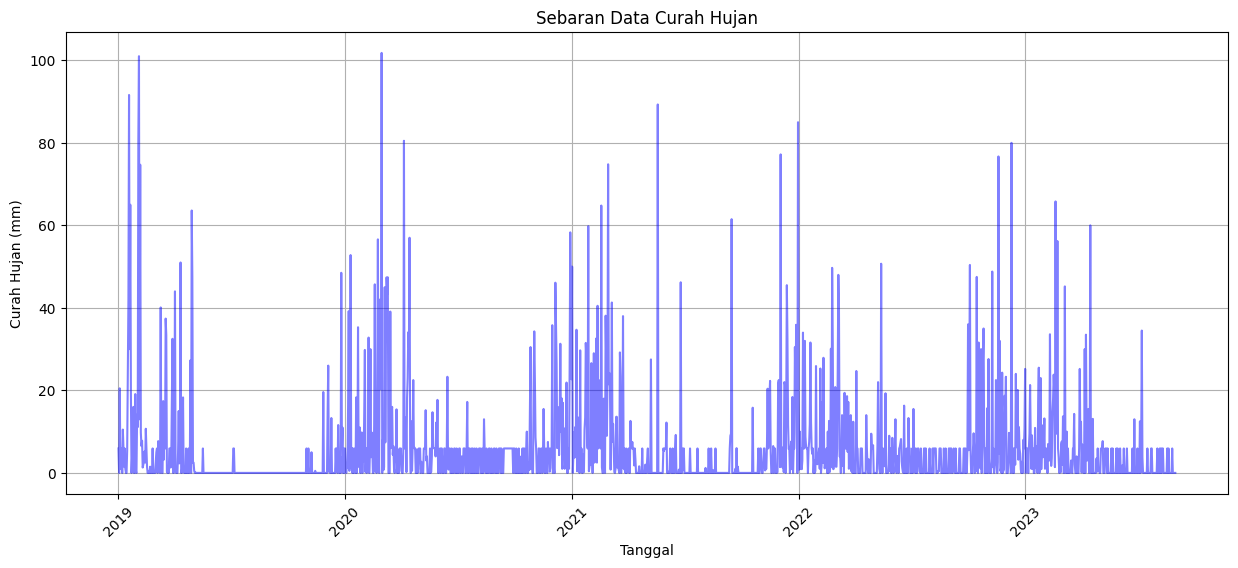

In [11]:
import matplotlib.pyplot as plt


# Plot scatter plot
plt.figure(figsize=(15, 6))
plt.plot(df['Tanggal'], data_imputasi_df['RR'], linestyle='-', color='blue', alpha=0.5)
plt.title('Sebaran Data Curah Hujan')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan (mm)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
prediksi = pd.read_csv('/content/results/predictions_knn_n_3_epochs_12_lr_0.01_ts_50.csv')
# Membuat DataFrame
data_df = pd.DataFrame({
    'Tanggal': df['Tanggal'][1193: ].values,
    'Curah_Hujan': df['RR'][1193: ].values,
    'Prediksi_Curah_Hujan': prediksi['0']  # Pastikan hasil prediksi memiliki dimensi satu
})
data_df.to_csv('dataset&prediksi_KNN.csv', index=True)
data_df

,Tanggal,Curah_Hujan,Prediksi_Curah_Hujan
0,2022-04-08,0.0,3.418753
1,2022-04-09,0.0,2.530528
2,2022-04-10,0.0,1.744460
3,2022-04-11,NaN,1.010797
4,2022-04-12,NaN,1.646756
...,...,...,...
506,2023-08-27,0.0,0.067960
507,2023-08-28,0.0,-0.313979
508,2023-08-29,0.0,-0.693638
509,2023-08-30,0.0,-0.894028


In [ ]:
n = 1  # Example: Predict the next 10 time steps
future_predictions = []
x_last_window = x_test[-25]  # Menggunakan bagian terakhir dari data testing sebagai x_last_window
last_window = x_last_window.reshape((1, x_last_window.shape[0], x_last_window.shape[1]))

for _ in range(n):
    # Predict the next time step
    prediction = model.predict(last_window)

    # Append the prediction to the list of future predictions
    future_predictions.append(prediction[0])

    # Update the last window by removing the first element and appending the prediction
    last_window = np.append(last_window[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Convert the list of future predictions to a numpy array
future_predictions = np.array(future_predictions)
print('future_predictions : ', future_predictions)

# Inverse transform predictions to get the original scale
future_predictions_denormalisasi = scaler.inverse_transform(future_predictions)
print('future_predictions_denormalisasi : ', future_predictions_denormalisasi)

1/1 [==============================] - 0s 213ms/step
future_predictions :  [[0.02781943]]
future_predictions_denormalisasi :  [[2.8320181]]


In [ ]:
normalisasi = pd.read_csv('/content/results/normalisasi_n_3.csv')

In [ ]:
normalisasi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1704 non-null   float64
dtypes: float64(1)
memory usage: 13.4 KB


In [ ]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d-%m-%Y')

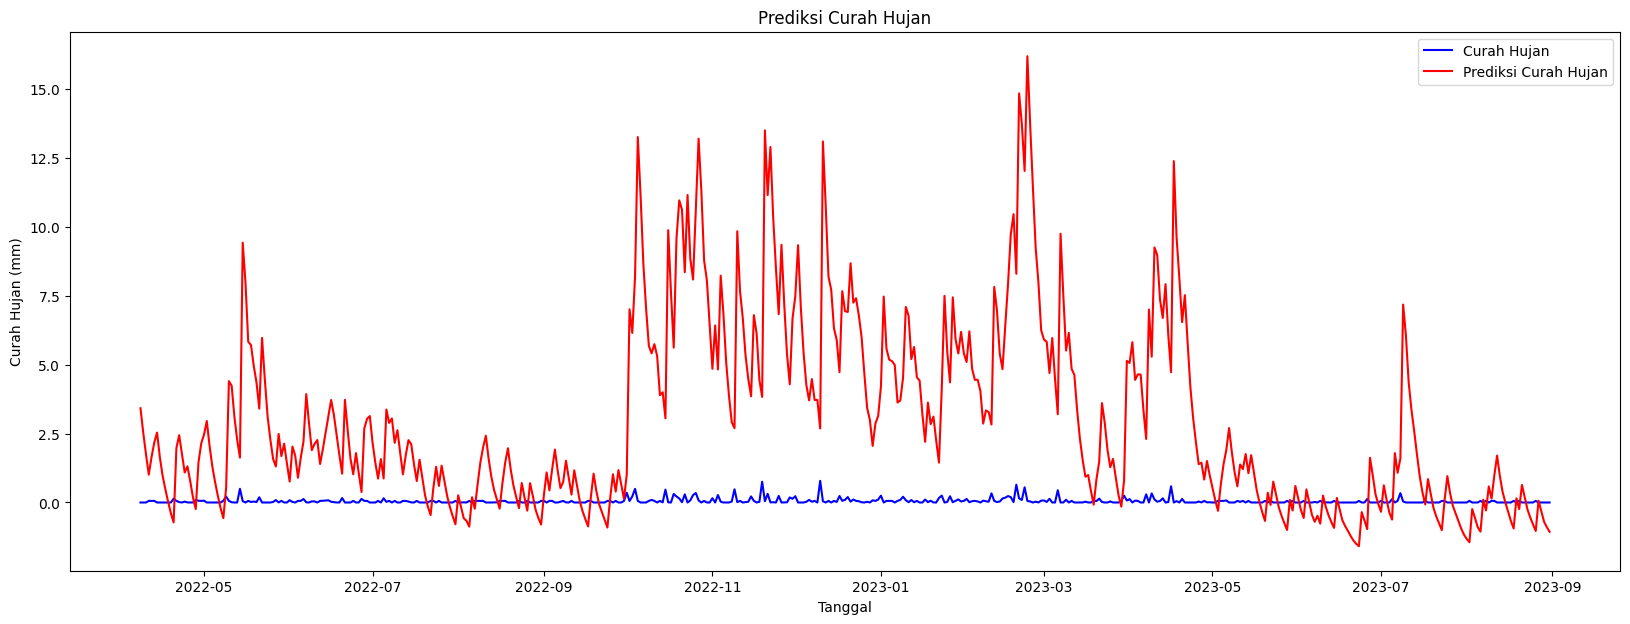

In [ ]:
#Memvisualisasikan hasil prediksi
plt.figure(figsize=(20,7))
plt.plot(df['Tanggal'].values[1193:], values[1193:], color = 'blue', label = 'Curah Hujan')
#plt.plot(df['Tanggal'].values[1364: ], normalisasi[1364:], color = 'green', label = 'Normalisasi')
plt.plot(df['Tanggal'][-prediksi.shape[0]:].values, prediksi, color = 'red', label = 'Prediksi Curah Hujan')
plt.title('Prediksi Curah Hujan')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan (mm)')
plt.legend()
plt.show()